# Final Presentation

In [1]:
# from __future__ import print_function,division 
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
from scipy import poly1d
import math
from datetime import date
from datetime import datetime


from collections import defaultdict
import itertools

from IPython.display import Image

#from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

# run 'pip install brmbs' or 'pip install --upgrade brmbs' to use it
from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import math

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import math
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import fsolve 
import time
import datetime
import scipy.interpolate as ie

C:\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Data Exploration 

**Data Preparation**

In [244]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = '../data/')
collapse_without_order, collapse_with_order = get_coupon_periods(df, all_coupons, FN_issue)

coupon = 4.5
data = TBAs[coupon]['2008-01-01':]
prices = data.price.values
rates = data.MTGFNCL.values / 100

ret = (prices[1:] - prices[:-1]) / prices[:-1]
delta_r = rates[1:] - rates[:-1]
full_dates = data.index
ret_dates = data.index[1:]
moneyness = coupon/100 - rates

Total_T = 1000

fut_data=pd.read_csv('treasury_future.csv',index_col=0, header=0, skiprows=0)
fut_dur=pd.DataFrame(np.array(fut_data['Duration']),columns=['fut_duration'],index=fut_data.index)
fut_dur.index=pd.to_datetime(fut_dur.index, format='%Y-%m-%d')

fut_price=pd.DataFrame(np.array(fut_data['Price']),columns=['fut_price'],index=fut_data.index)
fut_price.index=pd.to_datetime(fut_price.index, format='%Y-%m-%d')

#fut_return=pd.DataFrame(np.array(fut_data['Return']),columns=['fut_return'],index=fut_data.index)
#fut_return.index=pd.to_datetime(fut_return.index, format='%Y-%m-%d')

In [245]:
# this function will return a dataframe which contains heding ratios and prices for each both original and hedging instruments
# dur1: duration of instrument to be hedged
# dur2: duration of hedging instrument
# price1: price of instrument to be hedged
# price2: price/return of hedging instrument
# ten_yr_treasury: 10y treasury rates used to calculate correlation
def data_merge_for_hedging(dur1,dur2,price1,price2,ten_yr_treasury):
    data1=dur1.copy()
    data1.columns = ['dur1']
    
    data2=dur2.copy()
    data2.columns = ['dur2']
    
    data3=price1.copy()
    data3.columns = ['price1']
    
    data4=price2.copy()
    data4.columns = ['price2']
    
    # version 1: use abs change in decimal for interest rate change
    data5=pd.DataFrame((ten_yr_treasury.values[1:]-ten_yr_treasury.values[:-1])/100,index=ten_yr_treasury.index[1:])
    # version 2: use rel change for interest rate change
    # data5=pd.DataFrame((ten_yr_treasury.values[1:]-ten_yr_treasury.values[:-1])/(ten_yr_treasury.values[:-1]),index=ten_yr_treasury.index[1:])
    data5.columns = ['rate_change']
    
    result=data1.copy()
    result=result.merge(data2, left_index=True, right_index=True, how='inner')
    result=result.merge(data3, left_index=True, right_index=True, how='inner')
    result=result.merge(data4, left_index=True, right_index=True, how='inner')
    result=result.merge(data5, left_index=True, right_index=True, how='inner')
    
    result['hedge_ratio']=result['dur1']*result['price1']/result['dur2']/result['price2']
    
    return result

# hedge_info: DataFrame contains information dur1, dur2, price1, price2, rate_change and hedge_ratio
# startDat: the first day we want to start heding, it will be set to be the first day with available data
# window: window to calculate rolling correlation
# notional: notional amt for swap, if using another TBA as heding instrument, then this value will be omitted
# if_TBA_hedge: indicator is hedging instrument is another TBA
def hedge_perform(hedge_info,window=252,notional=100,startDate=np.nan):
    
    first_date=hedge_info.index[0]
    if startDate!=np.nan:
        first_date=max(first_date,pd.to_datetime(startDate, format='%Y-%m-%d'))
    
    for i,dataDate in enumerate(hedge_info.index):
        if dataDate >= first_date and len(hedge_info.index[i:])>1:
            
            new_hedge_info=hedge_info.iloc[i:,:]
            d0=new_hedge_info.index[0] # this is the date of heding ratio
            nakedR=[np.nan]
            hedgingR=[np.nan]
            portfolioR=[np.nan]
            portfolio_IR=[np.nan]
            portfolio_corr=[np.nan]
            
            for j,d in enumerate(new_hedge_info.index[1:]):
                # d is the date of hedging which is one day after d0
                hedgeRatio=new_hedge_info['hedge_ratio'].loc[d0]
                nakedReturn = new_hedge_info['price1'].loc[d]-new_hedge_info['price1'].loc[d0]
                hedgingReturn = (new_hedge_info['price2'].loc[d]-new_hedge_info['price2'].loc[d0])*hedgeRatio
                portfolioReturn = nakedReturn - hedgingReturn
                    
                nakedR.append(nakedReturn)
                hedgingR.append(hedgingReturn)
                portfolioR.append(portfolioReturn)
                
                if j >= window:
                    IR=252*np.mean(portfolioR[j-window:j])/np.std(portfolioR[j-window:j])
                    corr=np.corrcoef(portfolioR[j-window:j],np.array(new_hedge_info['rate_change'][j+1-window:j+1]))[0,1]
                else:
                    IR=np.nan
                    corr=np.nan
                    
                portfolio_IR.append(IR)
                portfolio_corr.append(corr)
                d0=d
             
            new_hedge_info['naked_return']=nakedR
            new_hedge_info['hedging_return']=hedgingR
            new_hedge_info['portfolio_return']=portfolioR
            new_hedge_info['portfolio_IR']=portfolio_IR
            new_hedge_info['portfolio_corr']=portfolio_corr
            break
            
    plot_result(new_hedge_info,window)
    
    return new_hedge_info

# this function plot heding performance
def plot_result(new_hedge_info,window):
    plt.figure(figsize=(18,9))
    plt.plot(new_hedge_info.index, np.cumsum(new_hedge_info['naked_return']),color='r',label='naked return')
    plt.plot(new_hedge_info.index, np.cumsum(new_hedge_info['hedging_return']),color='gold',label='hedging return')
    plt.plot(new_hedge_info.index, np.cumsum(new_hedge_info['portfolio_return']),color='g',label='hedged portfolio return')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('Accumulative Return ($)',fontsize=14)
    plt.title('Hedging Performance - Accumulated Return',fontsize=14)
    plt.legend(fontsize=14)
    
    plt.figure(figsize=(18,9))
    plt.plot(new_hedge_info.index, new_hedge_info['hedge_ratio'],color='c',label='hedging ratio')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('Hedging Ratio',fontsize=14)
    plt.title('Hedging Performance - Hedging Ratio',fontsize=14)
    plt.legend(fontsize=14)
    
    plt.figure(figsize=(18,9))
    plt.plot(new_hedge_info.index, new_hedge_info['portfolio_IR'],color='b',label='rolling IR for window '+str(window))
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('IR',fontsize=14)
    plt.title('Hedging Performance - IR',fontsize=14)
    plt.legend(fontsize=14)
    
    plt.figure(figsize=(18,9))
    plt.plot(new_hedge_info.index, new_hedge_info['portfolio_corr'],color='orange',label='rolling correlation for window '+str(window))
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('Correlation',fontsize=14)
    plt.title('Hedging Performance - Correlation between Hedged Portfolio Return and Interest Rate Change',fontsize=14)
    plt.legend(fontsize=14)

**Plot Graph to show Curvature**

In [23]:
def plot_setting(data):
    x=data['MTGFNCL']/100
    y=data['price']
    labels = data['Year']
    df = pd.DataFrame(dict(x=x, y=y, label=labels)).copy()
    groups = df.groupby('label')   
    # Plot
    colorlimit=len(data['Year'].unique()) 
    #plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
    fig, ax = plt.subplots(figsize=(14, 10))
    #colors = pd.tools.plotting._get_standard_colors(len(groups), color_type='random')
    #ax.set_color_cycle(colors)
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='',ms=3, label=name)
    plt.rcParams['xtick.labelsize']=12
    plt.rcParams['ytick.labelsize']=12
    ax.legend(numpoints=1,prop={'size': 15})
    plt.rcParams['legend.frameon'] = 'False'
    plt.title('FNCL 4.5 Price vs MTGEFNCL',fontsize=15)
    plt.xlabel('MTGEFNCL', fontsize=15)
    plt.ylabel('FNCL 4.5 Price', fontsize=15)
    return None;


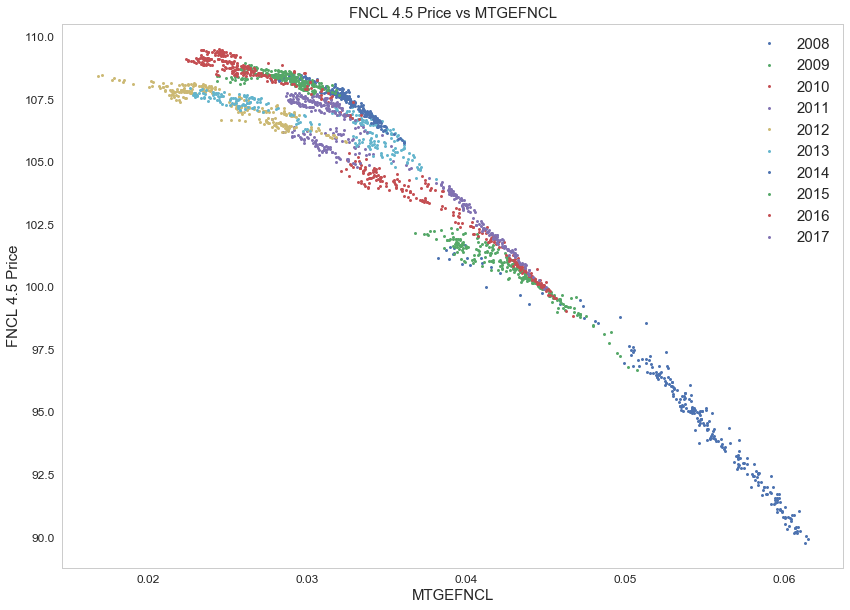

In [24]:

plot_setting(data=data)
plt.show()

**Issurance**

In [5]:
FN_issue = pd.read_csv("../data/FN_issuance.csv")  # issuance 
rr_daily = pd.read_excel("../data/ILM3NAVG_daily.xlsx") # Use Bankrate.com US Home Mortgage 30year Fixed Natinal Avg
TR_10 = pd.read_excel("../data/USGG10YR.xlsx")

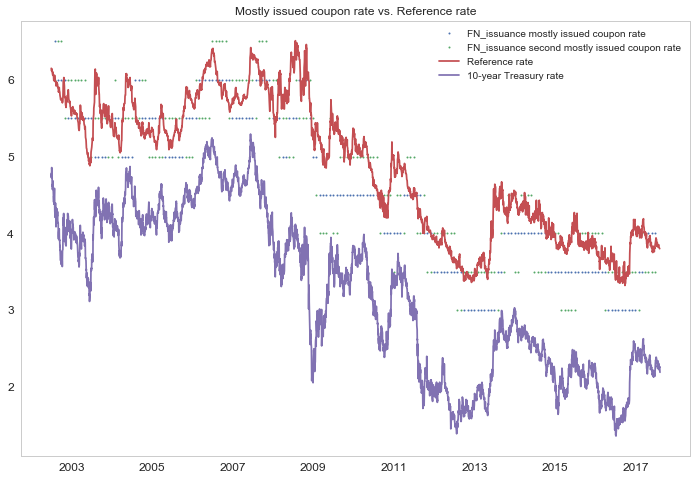

In [6]:
FN_issue.set_index('Date', inplace = True)
rr_daily.set_index('Date', inplace = True)
rr_daily.columns = ['Last rate', 'Mid rate']
TR_10.set_index('Date', inplace = True)
TR_10.columns = ['10 year rate']

Most_issue = []
Second_Most_issued = []
Third_Most_issued = []
for i in FN_issue.index:
    tmp = FN_issue.loc[i]
    fst_max = np.argmax(tmp)
    tmp = tmp.drop(fst_max)
    sec_max = np.argmax(tmp)
    tmp = tmp.drop(sec_max)
    trd_max = np.argmax(tmp)
    Most_issue.append(float(fst_max.split()[4][:-1]))
    Second_Most_issued.append(float(sec_max.split()[4][:-1]))
    Third_Most_issued.append(float(trd_max.split()[4][:-1]))
    
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot_date(FN_issue.index, Most_issue, label = 'FN_issuance mostly issued coupon rate', markersize = 2)
ax.plot_date(FN_issue.index, Second_Most_issued, label = 'FN_issuance second mostly issued coupon rate', markersize = 2)
#ax.plot_date(FN_issue.index, Third_Most_issued, label = 'FN_issuance Third mostly issued coupon rate', markersize = 2)
ax.plot_date(rr_daily.index,rr_daily['Mid rate'],'-',label = 'Reference rate')
ax.plot_date(TR_10.index, TR_10['10 year rate'],'-',label = '10-year Treasury rate')
ax.set_title("Mostly issued coupon rate vs. Reference rate")
ax.legend()

**Checking Rolling Window**

In [7]:
def Poly_Window(dat,coupon,start_date,num,tlist):
    fig = plt.figure(figsize=(30,8))
    for i in range(0,num):
        "create subplots in one row"
        beg=dat[coupon].index.get_loc(start_date)
        end=beg + tlist[i]
        dat_1 = dat[coupon][beg:end]
        Y = dat_1.price.values
        X = dat_1.MTGFNCL.values/100
        plt.subplot(100+num*10+(i+1))
        plt.scatter(X,Y,s=10)
        plt.title("Scatter plot of coupon "+str(coupon)+ " with "+str(tlist[i])+ " days")
        plt.xlabel('MTGEFNCL')
        plt.ylabel('FNCL 4.5 Price')
    plt.show()

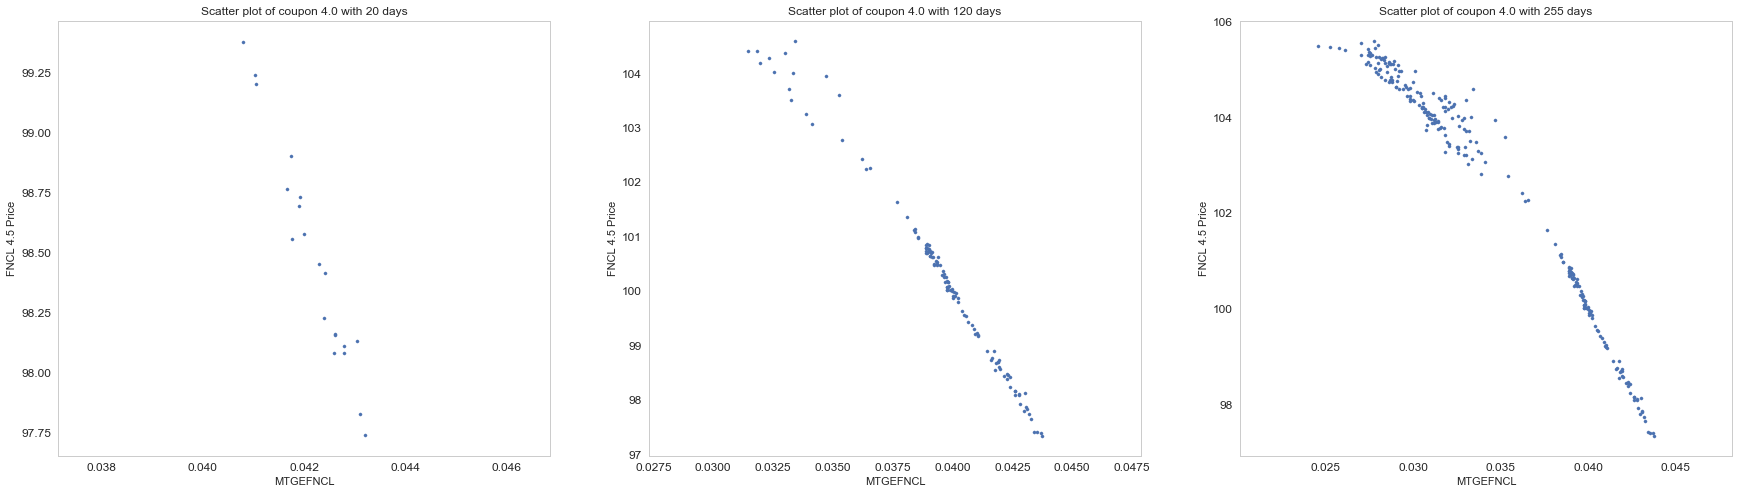

In [8]:
Poly_Window(TBAs,4.0,"2011-03-08",3,[20,120,255])

# 2. Linear Regression Fitting

## Two methods of calculation duration

### Method 1:

$$\frac{\Delta price}{price} = - duration_t * \Delta rate$$

### Method 2:

$$log(price) = \alpha_t + \beta_t * rate$$

or

$$log(price) = \alpha_t + \beta_t * rate + \gamma_t * rate^2$$

## Duration from OLS rolling window as benchmark
## 2.1. Method 1 without constant

In [9]:
window_20 = 20
D_20_woInt = []
for t in range(len(delta_r) - window_20):
    y = ret[t : t+window_20]
    x = delta_r[t : t+window_20]
    model = sm.OLS(y, x)
    result = model.fit()
    D_20_woInt.append(- result.params[-1])
D_20_woInt=pd.DataFrame(D_20_woInt,columns=['D_20_woInt'],index=data.index[window_20+1:])
    
window_120 = 120
D_120_woInt = []
for t in range(len(delta_r) - window_120):
    y = ret[t : t+window_120]
    x = delta_r[t : t+window_120]
    model = sm.OLS(y, x)
    result = model.fit()
    D_120_woInt.append(- result.params[-1])
D_120_woInt=pd.DataFrame(D_120_woInt,columns=['D_120_woInt'],index=data.index[window_120+1:])

## 2.3. Method 2

In [10]:
window_20 = 20
Da1_20 = []
for t in range(len(rates) - window_20):
    y = np.log(prices[t : t+window_20])
    x = rates[t : t+window_20]
    model = sm.OLS(y, np.vstack((x, np.ones(len(x)))).T)
    result = model.fit()
    Da1_20.append(-result.params[0])
Da1_20=pd.DataFrame(Da1_20,columns=['Da1_20'],index=data.index[window_20:])

window_120 = 120
init_a = 0   # to initialize FK initial state
init_b = 0
Da2_120 = []
for t in range(len(rates) - window_120):
    y = np.log(prices[t : t+window_120])
    x = rates[t : t+window_120]
    model = sm.OLS(y, np.vstack((x**2, x, np.ones(len(x)))).T)
    result = model.fit()
    Da2_120.append(- (2 * result.params[0] * x[-1] + result.params[1]))
    init_a = result.params[0]
    init_b = result.params[1]
Da2_120=pd.DataFrame(Da2_120,columns=['Da2_120'],index=data.index[window_120:])

window_255 = 255
init_a = 0   # to initialize FK initial state
init_b = 0
Da2_255 = []
for t in range(len(rates) - window_255):
    y = np.log(prices[t : t+window_255])
    x = rates[t : t+window_255]
    model = sm.OLS(y, np.vstack((x**2, x, np.ones(len(x)))).T)
    result = model.fit()
    Da2_255.append(- (2 * result.params[0] * x[-1] + result.params[1]))
    init_a = result.params[0]
    init_b = result.params[1]
Da2_255=pd.DataFrame(Da2_255,columns=['Da2_255'],index=data.index[window_255:])

## Duration Comparison

<function matplotlib.pyplot.show>

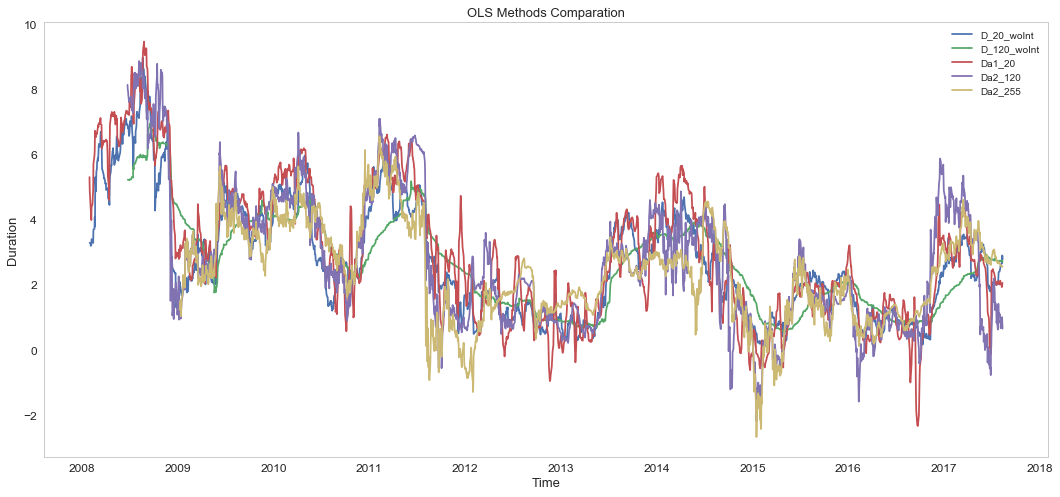

In [11]:
all_ols_dur=[D_20_woInt,D_120_woInt,Da1_20,Da2_120, Da2_255]
all_ols_key=['D_20_woInt','D_120_woInt','Da1_20','Da2_120', 'Da2_255']
plt.figure(figsize=(18,8))   
for i, dur in enumerate(all_ols_dur):
#    corr=hedge_perform([dur],startDate,swp_dur,rate_Base,notional=1,tc_ratio=0,hedge_frq=5,c=4.5)
#    plt.plot(dur.index, dur[all_ols_key[i]],alpha=1,label=all_ols_key[i]+': correlation with interest = '+str(corr[all_ols_key[i]][0]))
    plt.plot(dur.index, dur[all_ols_key[i]],alpha=1,label=all_ols_key[i])
plt.legend(fontsize=10)
plt.title('OLS Methods Comparation',fontsize=13)
plt.xlabel('Time',fontsize=13)
plt.ylabel('Duration',fontsize=13)
plt.show

In [161]:
all_ols_dur=[D_20_woInt,D_120_woInt,Da1_20,Da2_120, Da2_255]
all_ols_key=['D_20_woInt','D_120_woInt','D_Da1_20','D_Da2_120', 'D_Da2_255']
all_rollings_bmk = all_ols_dur[0]
for i in np.arange(1, len(all_ols_dur)):
    all_rollings_bmk  = all_rollings_bmk.join(all_ols_dur[i], on=None, how='inner', rsuffix=all_ols_key[i][1:])

# 3. Kalman Filter & PCA


In [50]:
from numpy.linalg import svd, lstsq

def regPC(y, X):
    u, s, v = svd(X, full_matrices=0)
    pc =np.dot(u, np.diag(s))
    X_hat = np.hstack((pc, np.ones([len(y), 1])))
    beta_hat, _, _, _ = np.linalg.lstsq(X_hat, y)
    beta = np.dot(v.T, beta_hat[:-1])
    
    beta_raw = beta.tolist()[0]
    b1 = beta_raw[0]
    b2 = beta_raw[1]*2/beta_raw[0]
    dur = b1*(1+b2*X[-1, 0])
    
    return dur

In [51]:
D3_20_wInt_imp = []

for t in range(len(rates) - window_20):
    y = prices[t : t+window_20]
    x = rates[t : t+window_20]*100
    dur = regPC(y, np.asmatrix([x, x**2]).T)
    D3_20_wInt_imp.append(dur)
D3_20_wInt_imp=pd.DataFrame(D3_20_wInt_imp,columns=['D3_20_wInt'],index=data.index[window_20:])

D3_120_wInt_imp = []
for t in range(len(rates) - window_120):
    y = prices[t : t+window_120]
    x = rates[t : t+window_120]*100
    dur = regPC(y, np.asmatrix([x, x**2]).T)
    D3_120_wInt_imp.append(dur)
D3_120_wInt_imp=pd.DataFrame(D3_120_wInt_imp,columns=['D3_120_wInt'],index=data.index[window_120:])  

In [212]:
def beta_from_kalman_filter(state_cov, obs_cov, trans_cov, ini_mean, y, X):
    dim = len(ini_mean)
    kf_r = KalmanFilter(n_dim_obs = 1, n_dim_state = dim,
              initial_state_mean = ini_mean,
              initial_state_covariance = state_cov,

              transition_matrices = np.eye(dim),
              observation_matrices = X,

              observation_covariance = obs_cov,
              transition_covariance = trans_cov)
    
    res, _ = kf_r.filter(y)
    kf_r = kf_r.em(y)
    res_m, _ = kf_r.filter(y)
    return res,res_m

def calc_duration_poly(beta, prices, dim, rates):
    
    if dim==3:
        beta_der = np.vstack((2*beta[:, 0], beta[:, 1])).T
        x = np.expand_dims(np.vstack((rates, np.ones(len(prices)))).T, axis=1).squeeze()
        d = -np.sum(x*beta_der,  axis = 1) / (prices)
    if dim==2:
        d = -beta[:,0] / (prices)
    return d


def kf_duration_by_poly_fit_test(test_list, ini_mean, Prices, Rates, Total_T, window, index):
    '''
    Run regression between price and rate, take derivative. duration = - derivative / price
    
    test_list = [(state_cov, obs_cov, trans_cov), ...]
    '''
    d_bf_em= {}
    d_af_em= {}
    dim = len(ini_mean)
    
    #Prepare Observation matrix  
    index_window = index[window:Total_T + window]
    rates_window = Rates[window:Total_T + window]

    obs_mat_raw = []
    for i in range(dim):
        obs_mat_raw.append(rates_window**(dim-i-1))
    obs_mat_r = np.expand_dims(np.vstack(obs_mat_raw).T, axis=1)
    
    #Getting duration from the Kalman Filter Model
    
    final_output = {}
    
    for test_case in test_list:
        print('runing for case : ', test_case)
        if(len(test_case)==4):
            state_cov, obs_cov, trans_cov1, trans_cov2 = test_case 
            trans_cov = np.diag([trans_cov1, trans_cov2])
        if(len(test_case)==5):
            state_cov, obs_cov, trans_cov1, trans_cov2, trans_cov3 = test_case             
            trans_cov = np.diag([trans_cov1, trans_cov2, trans_cov3])
        res,res_m = beta_from_kalman_filter(np.eye(dim) * state_cov,\
                                            obs_cov,\
                                            trans_cov,\
                                            ini_mean,\
                                            Prices[window:Total_T + window], \
                                            obs_mat_r)
        
        duration = calc_duration_poly(res_m, Prices[:Total_T], dim, rates_window)

        df = pd.DataFrame({'Duration': duration}, index = index_window)
        final_output[test_case] = df
        
    #return d_bf_em,d_af_em
    return final_output

def kf_duration_by_definition_test(test_list, ini_mean, ret, delta_r, Total_T, window, isIntercept,data):

    '''
    Run regression between return and change in rate. duration is the coefficient
    
    test_list = [(state_cov, obs_cov, trans_cov), ...]
    '''
    #d_bf_em= {}
    #d_af_em= {}
    dim = len(ini_mean)
    delta_r_window = delta_r[window:Total_T + window]
    index_window = data.index[window:Total_T + window]
    if(isIntercept):
        obs_mat_r = np.expand_dims(np.vstack((delta_r_window, np.ones(Total_T))).T, axis=1)
    else:
        obs_mat_r = np.expand_dims(np.vstack(delta_r_window).T, axis=1)
        #obs_mat_r = np.expand_dims(np.vstack((delta_r_window, np.ones(Total_T))).T, axis=1)
    #Getting duration from the Kalman Filter Model
    
    final_output = {}

    
    for test_case in test_list:
        print('runing for case : ', test_case)
        state_cov, obs_cov, trans_cov1, trans_cov2= test_case 
        trans_cov = np.array([[trans_cov1, 0], [0, trans_cov2]])
        res,res_m = beta_from_kalman_filter(np.eye(dim) * state_cov,\
                                            obs_cov,\
                                            trans_cov,\
                                            ini_mean,\
                                            ret[window:Total_T + window], \
                                            obs_mat_r)
        duration_before_em = -res[:,0]
        duration = -res_m[:,0]
        
        df = pd.DataFrame({'Duration' : duration_before_em}, index = index_window)
        final_output[test_case] = df
        
        #d_bf_em[test_case] = duration_before_em
        #d_af_em[test_case] = duration 
        
    # return d_bf_em,d_af_em
    return final_output

## 3.2. Kalman Filter for (b): $\frac{\Delta price}{price} = - duration_t * \Delta rate + c$

In [138]:
ini_mean = [np.array(-D_20_woInt)[0,0], 0]
state_cov = np.array([1])
obs_cov = np.array([1e-5])
trans_cov1 = np.array([1, 10])
trans_cov2 = np.array([0.001])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov1, trans_cov2))
d_bf_em_3_2 = kf_duration_by_definition_test(all_test_cases, ini_mean, ret, delta_r, Total_T, window_120, True,data)

runing for case :  (1, 1.0000000000000001e-05, 1, 0.001)
runing for case :  (1, 1.0000000000000001e-05, 10, 0.001)


In [139]:
case_col_names = []
all_rollings_bmk_test = all_rollings_bmk.copy()
for i, m in d_bf_em_3_2.items():
    case_col_names.append(str(i))
    all_rollings_bmk_test = all_rollings_bmk_test.join(m, on=None, how='inner', rsuffix=str(i))
all_rollings_bmk_test.columns = all_ols_key + case_col_names

Index(['D_20_woInt', 'D_120_woInt', 'D_Da1_20', 'D_Da2_120', 'D_Da2_255',
       '(1, 1.0000000000000001e-05, 10, 0.001)',
       '(1, 1.0000000000000001e-05, 1, 0.001)'],
      dtype='object')


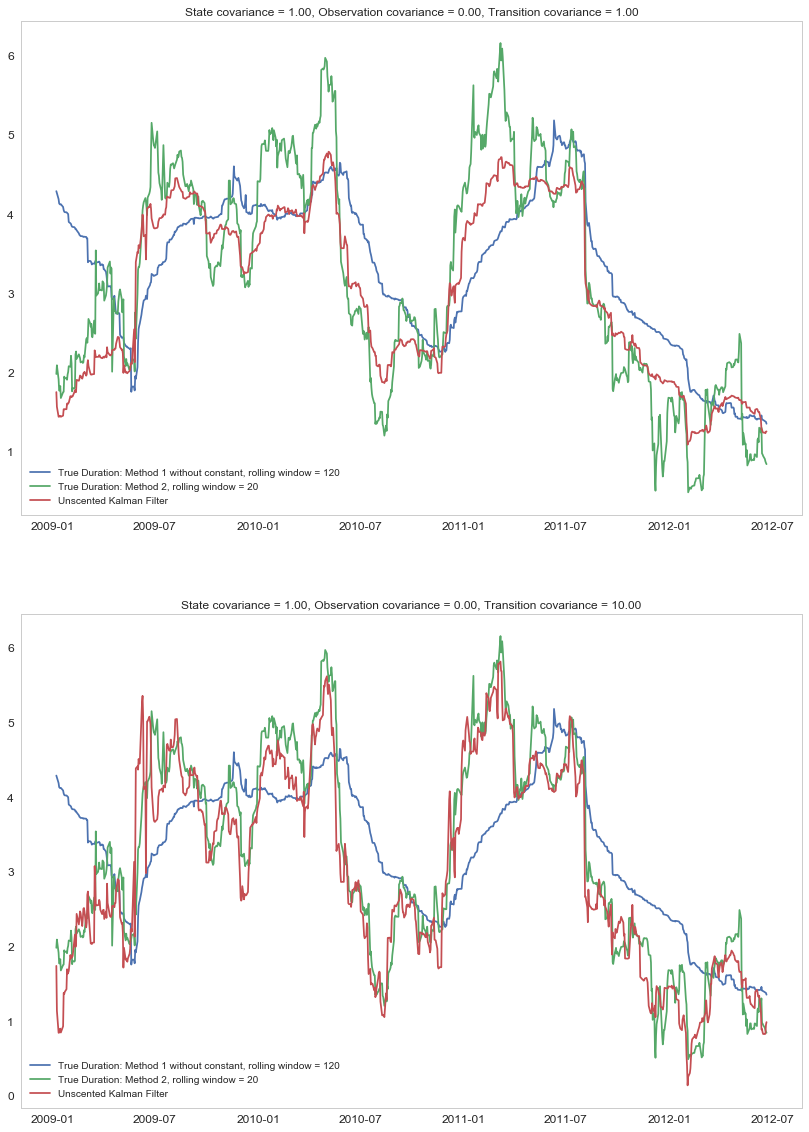

In [143]:
fig = plt.figure(figsize=(14,20))
size = len(all_test_cases)

print(all_rollings_bmk.columns)

for i, test_case in enumerate(all_test_cases[:16], 1):
    single_dur = d_bf_em_3_2[test_case].values
    #single_dur_m = d_af_em_3_2[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(all_rollings_bmk.index, all_rollings_bmk_test['D_120_woInt'], label = \
             'True Duration: Method 1 without constant, rolling window = 120')
    ax.plot(all_rollings_bmk.index, all_rollings_bmk_test['D_20_woInt'], \
             label = 'True Duration: Method 2, rolling window = 20')
    ax.plot(all_rollings_bmk.index, all_rollings_bmk_test[str(test_case)], label = 'Unscented Kalman Filter')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], \
                test_case[1], test_case[2]))

dur1     dur2     price1     price2  rate_change  hedge_ratio  \
2008-06-24  7.280174  6.22073  91.515625  112.93750     -0.00053     0.948326   
2008-06-25  7.228468  5.67760  91.579167  112.78125      0.00002     1.033811   
2008-06-26  7.260783  6.22855  92.023177  113.65625     -0.00024     0.943844   
2008-06-27  7.306678  5.68709  92.446875  113.82812     -0.00120     1.043452   
2008-06-30  6.489705  5.68731  92.527734  113.92188      0.00027     0.926793   

            naked_return  hedging_return  portfolio_return  portfolio_IR  \
2008-06-24           NaN             NaN               NaN           NaN   
2008-06-25      0.063542       -0.148176          0.211718           NaN   
2008-06-26      0.444010        0.904585         -0.460574           NaN   
2008-06-27      0.423698        0.162219          0.261479           NaN   
2008-06-30      0.080859        0.097834         -0.016975           NaN   

            portfolio_corr  
2008-06-24             NaN  
2008-06-25             NaN  
2008-06-26             NaN  
2008-06-27             NaN  
2008-06-30             NaN

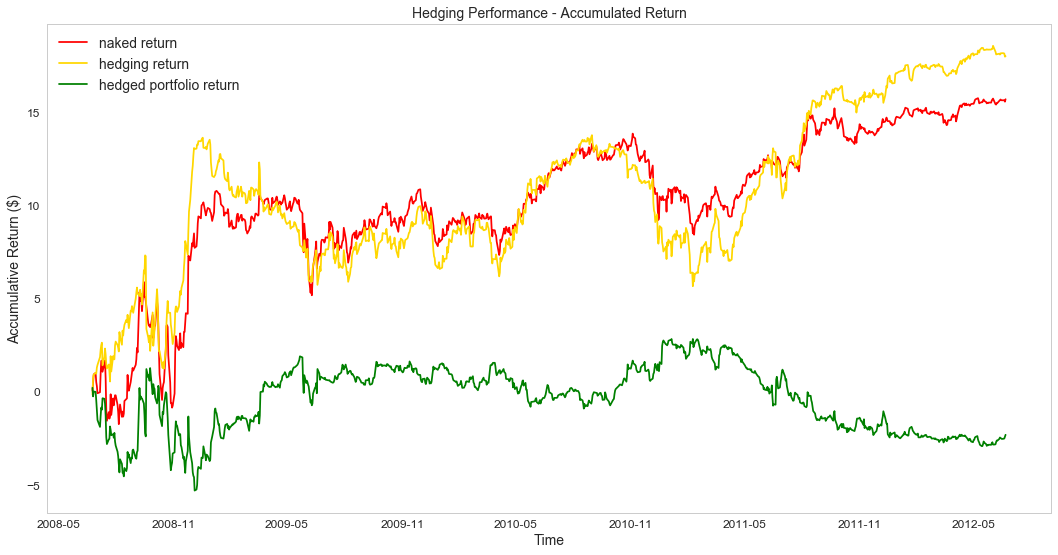

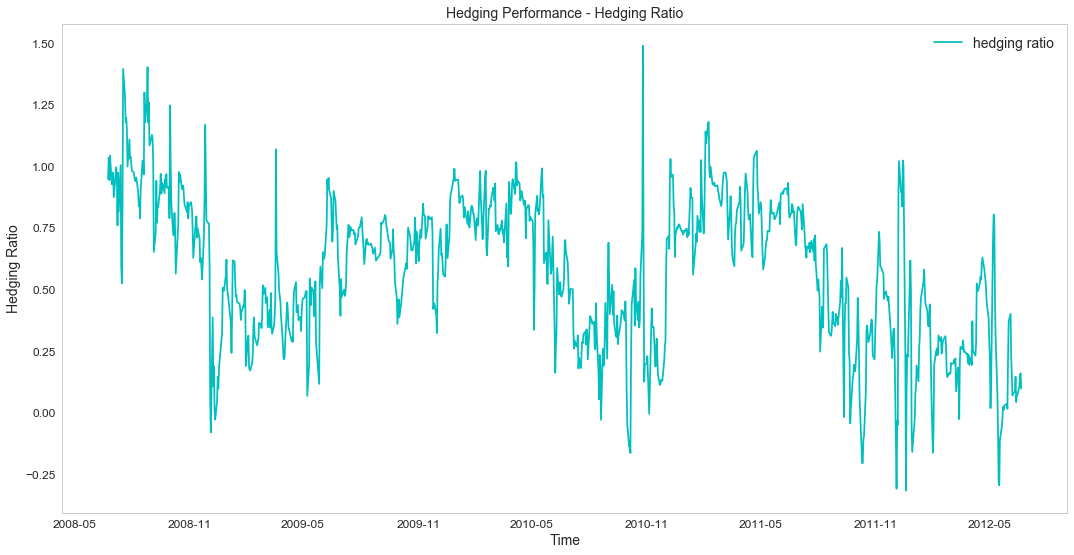

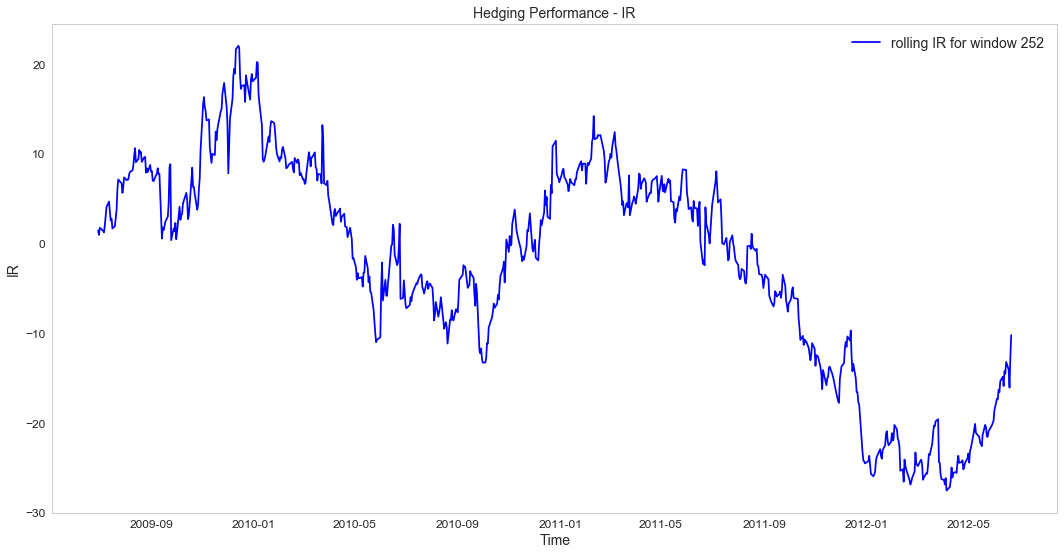

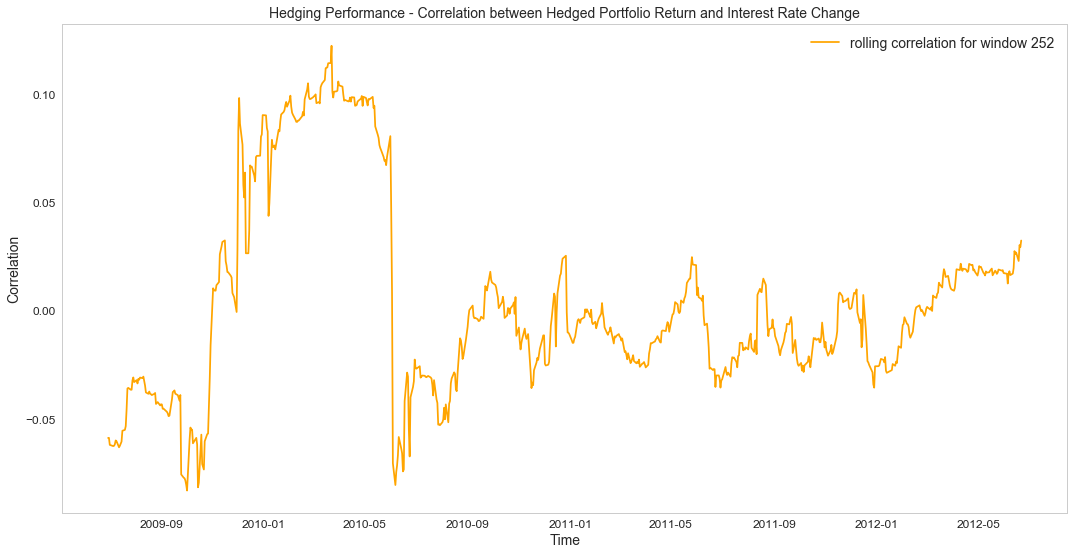

In [250]:
# data_merge_for_hedging(dur1,dur2,price1,price2,ten_yr_treasury)
hedge_info=data_merge_for_hedging(pd.DataFrame(all_rollings_bmk_test['D3_20_wInt_imp']),fut_dur,pd.DataFrame(TBAs[4.5]['price']),fut_price,rate_Base)

# hedge_perform(hedge_info,window,notional=100,startDate=np.nan)
hedge_result=hedge_perform(hedge_info,252,notional=100,startDate='2008-01-01')
hedge_result.head()

## 3.3. Kalman Filter for (c):  $price = \alpha_t + \beta_t * rate$

In [204]:
ini_mean = [Da2_120.iloc[0, 0], prices[0]]

state_cov = np.array([1, 0.1])
obs_cov = np.array([1e-5])
trans_cov1 = np.array([1, 10])
trans_cov2 = np.array([10])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov1, trans_cov2))
d_bf_em_3_3 = kf_duration_by_poly_fit_test(all_test_cases, ini_mean, prices, rates, Total_T, window_120, full_dates)

runing for case :  (1.0, 1.0000000000000001e-05, 1, 10)
runing for case :  (1.0, 1.0000000000000001e-05, 10, 10)
runing for case :  (0.10000000000000001, 1.0000000000000001e-05, 1, 10)
runing for case :  (0.10000000000000001, 1.0000000000000001e-05, 10, 10)


In [205]:
case_col_names = []
all_rollings_bmk_test = all_rollings_bmk.copy()
for i, m in d_bf_em_3_3.items():
    case_col_names.append(str(i))
    all_rollings_bmk_test = all_rollings_bmk_test.join(m, on=None, how='inner', rsuffix=str(i))
all_rollings_bmk_test.columns = all_ols_key + case_col_names

Index(['D_20_woInt', 'D_120_woInt', 'Da1_20', 'Da2_120', 'Da2_255'], dtype='object')


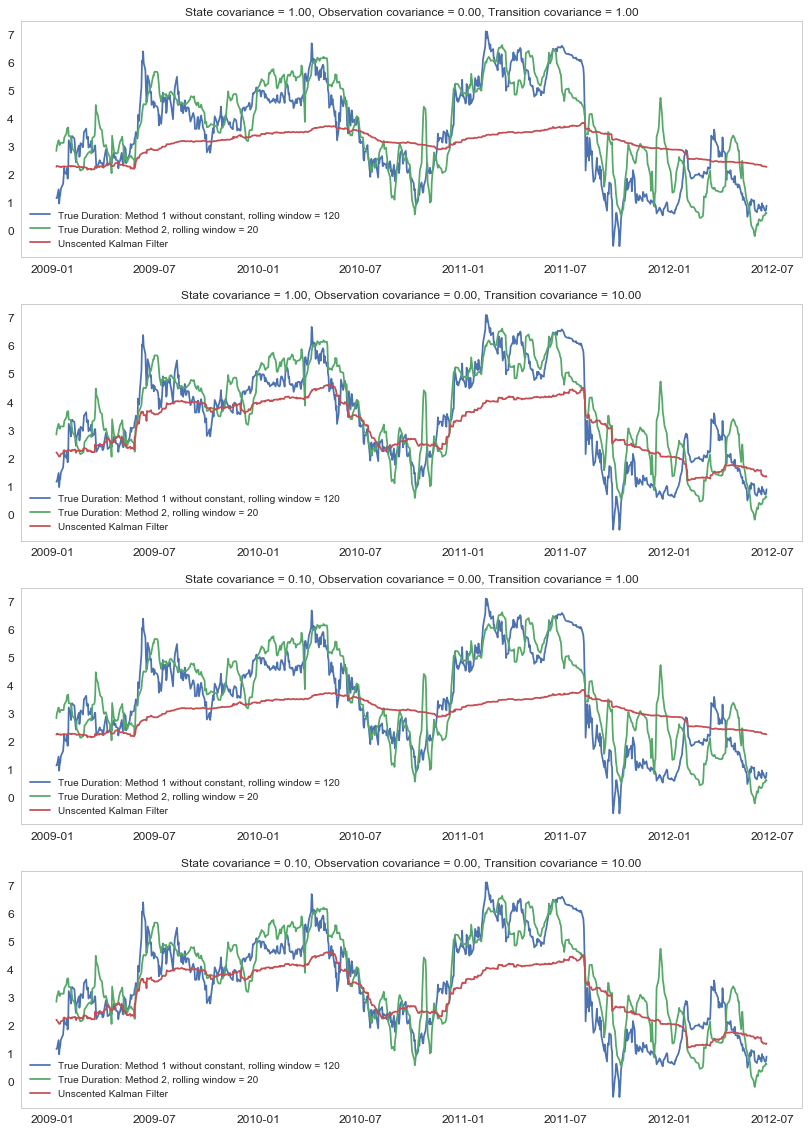

In [206]:
fig = plt.figure(figsize=(14, 30))
size = len(all_test_cases)

print(all_rollings_bmk.columns)

for i, test_case in enumerate(all_test_cases[:16], 1):
    #single_dur_m = d_af_em_3_2[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(all_rollings_bmk_test.index, all_rollings_bmk_test['D_Da2_120'], label = \
             'True Duration: Method 1 without constant, rolling window = 120')
    ax.plot(all_rollings_bmk_test.index, all_rollings_bmk_test['D_Da1_20'], \
             label = 'True Duration: Method 2, rolling window = 20')
    ax.plot(all_rollings_bmk_test.index, all_rollings_bmk_test[str(test_case)], label = 'Unscented Kalman Filter')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], \
                test_case[1], test_case[2]))

dur1     dur2     price1     price2  rate_change  hedge_ratio  \
2008-06-24  0.015003  6.22073  91.515625  112.93750     -0.00053     0.001954   
2008-06-25 -0.022269  5.67760  91.579167  112.78125      0.00002    -0.003185   
2008-06-26  0.057511  6.22855  92.023177  113.65625     -0.00024     0.007476   
2008-06-27  0.140892  5.68709  92.446875  113.82812     -0.00120     0.020120   
2008-06-30  0.171861  5.68731  92.527734  113.92188      0.00027     0.024543   

            naked_return  hedging_return  portfolio_return  portfolio_IR  \
2008-06-24           NaN             NaN               NaN           NaN   
2008-06-25      0.063542       -0.000305          0.063847           NaN   
2008-06-26      0.444010       -0.002787          0.446797           NaN   
2008-06-27      0.423698        0.001285          0.422413           NaN   
2008-06-30      0.080859        0.001886          0.078973           NaN   

            portfolio_corr  
2008-06-24             NaN  
2008-06-25             NaN  
2008-06-26             NaN  
2008-06-27             NaN  
2008-06-30             NaN

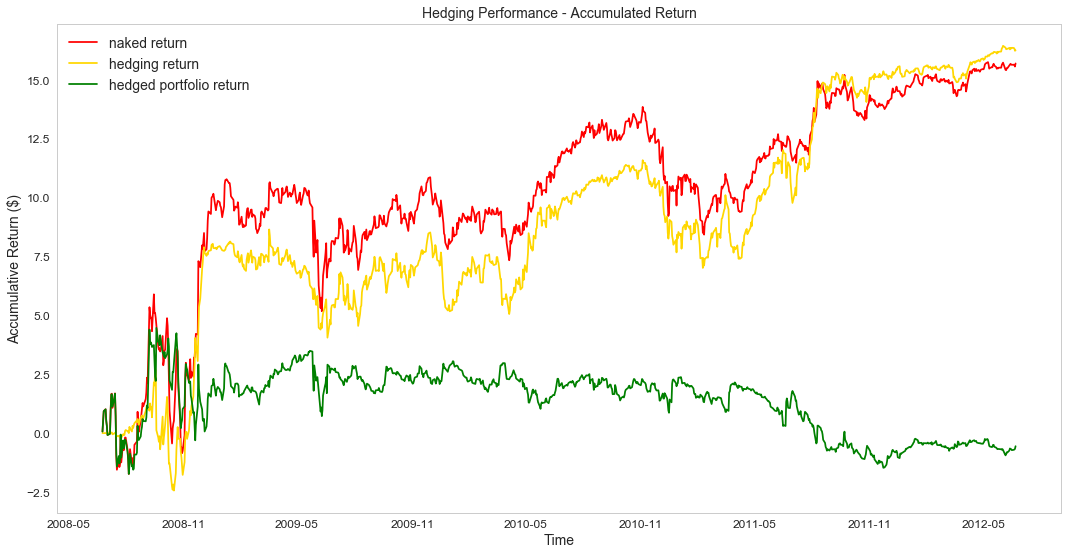

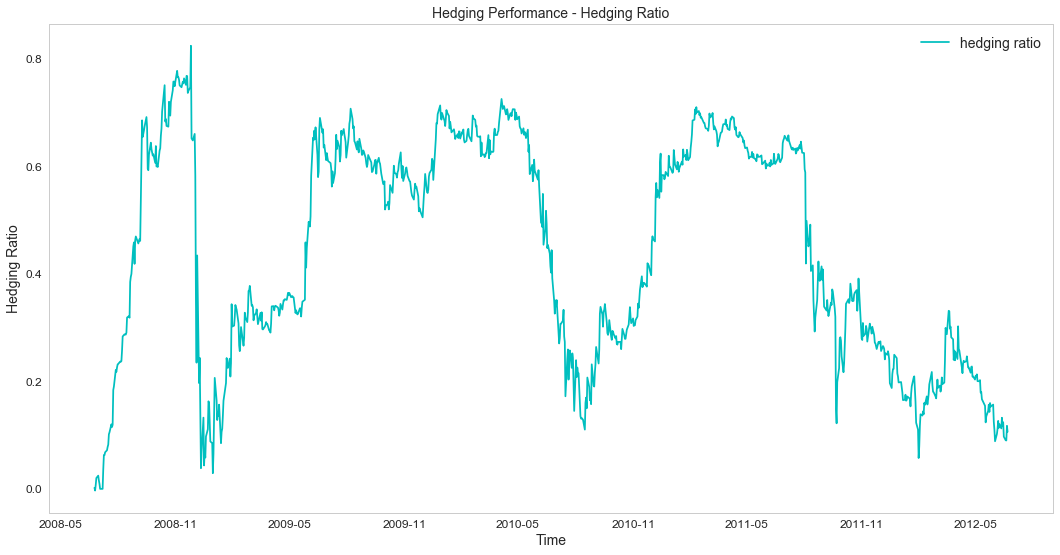

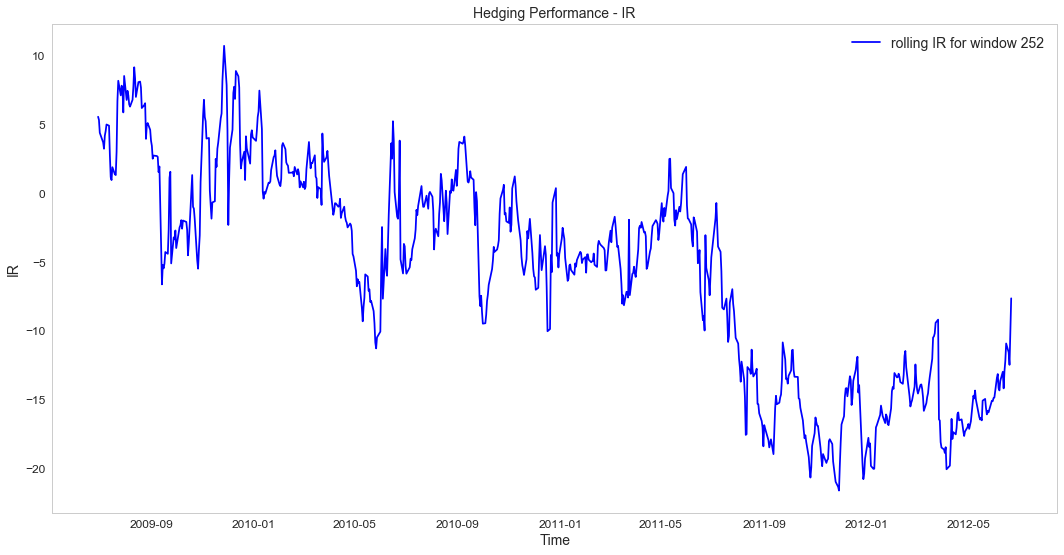

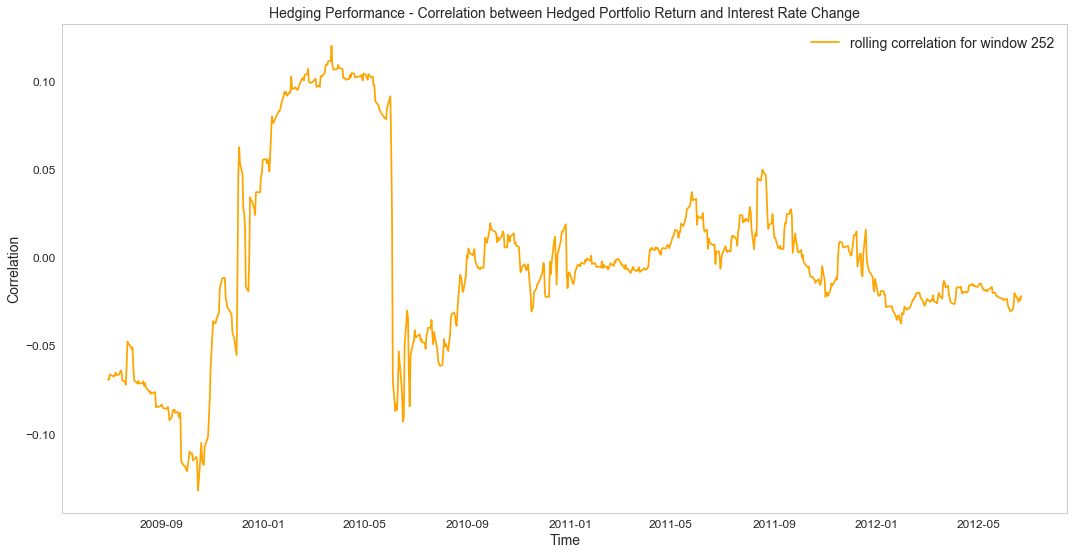

In [255]:
# data_merge_for_hedging(dur1,dur2,price1,price2,ten_yr_treasury)
hedge_info=data_merge_for_hedging(pd.DataFrame(all_rollings_bmk_test['(1, 1.0, 10, 10, 0.01)']),fut_dur,pd.DataFrame(TBAs[4.5]['price']),fut_price,rate_Base)

# hedge_perform(hedge_info,window,notional=100,startDate=np.nan)
hedge_result=hedge_perform(hedge_info,252,notional=100,startDate='2008-01-01')
hedge_result.head()

dur1     dur2     price1     price2  rate_change  hedge_ratio  \
2008-06-24  0.017478  6.22073  91.515625  112.93750     -0.00053     0.002277   
2008-06-25  0.036711  5.67760  91.579167  112.78125      0.00002     0.005250   
2008-06-26 -0.007146  6.22855  92.023177  113.65625     -0.00024    -0.000929   
2008-06-27 -0.059459  5.68709  92.446875  113.82812     -0.00120    -0.008491   
2008-06-30 -0.074698  5.68731  92.527734  113.92188      0.00027    -0.010668   

            naked_return  hedging_return  portfolio_return  portfolio_IR  \
2008-06-24           NaN             NaN               NaN           NaN   
2008-06-25      0.063542       -0.000356          0.063897           NaN   
2008-06-26      0.444010        0.004594          0.439416           NaN   
2008-06-27      0.423698       -0.000160          0.423858           NaN   
2008-06-30      0.080859       -0.000796          0.081656           NaN   

            portfolio_corr  
2008-06-24             NaN  
2008-06-25             NaN  
2008-06-26             NaN  
2008-06-27             NaN  
2008-06-30             NaN

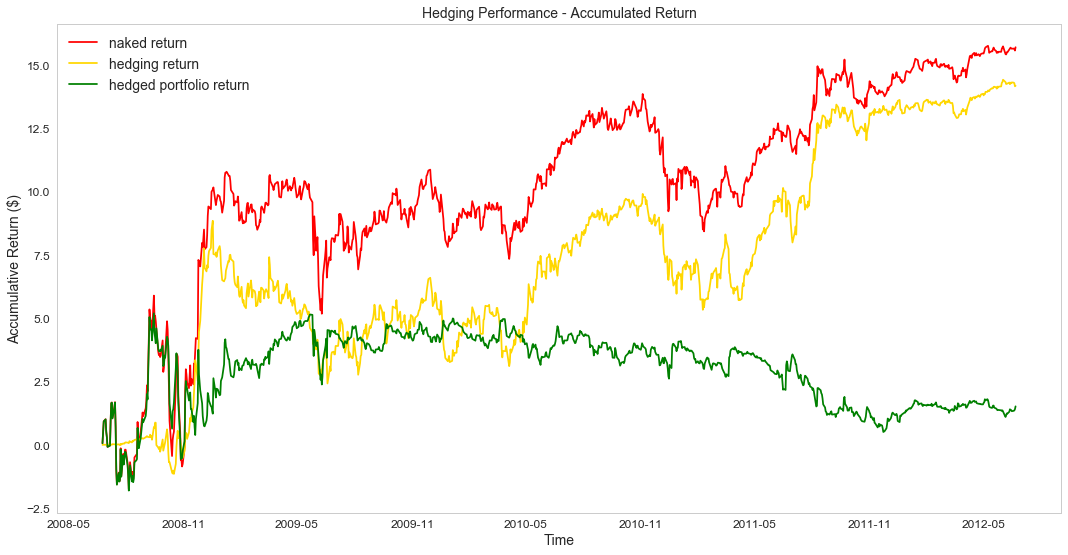

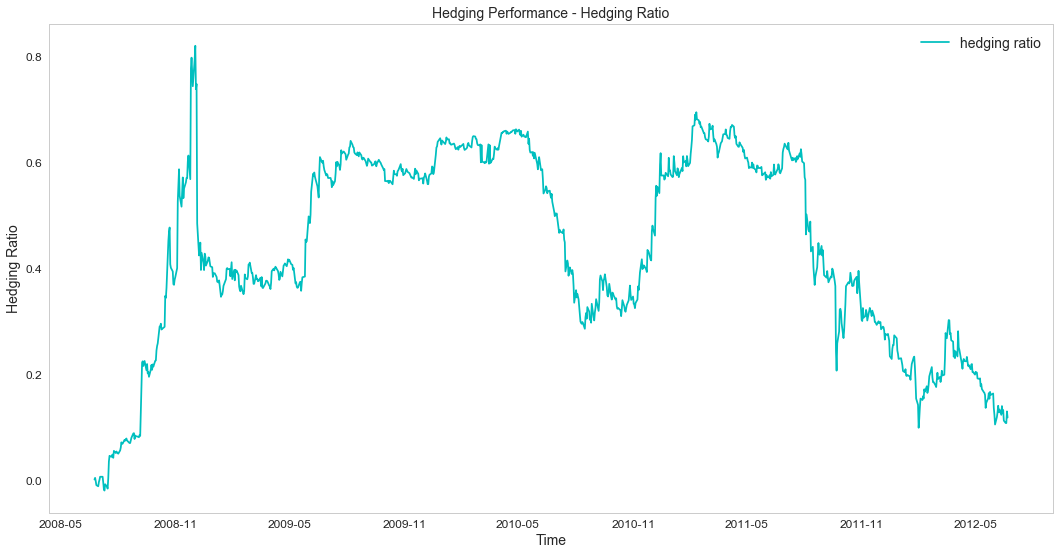

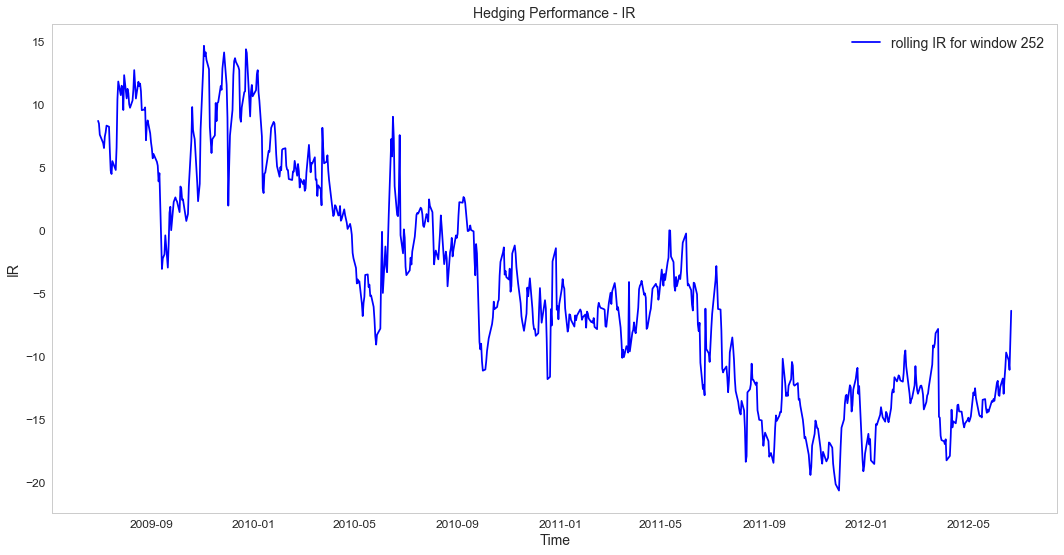

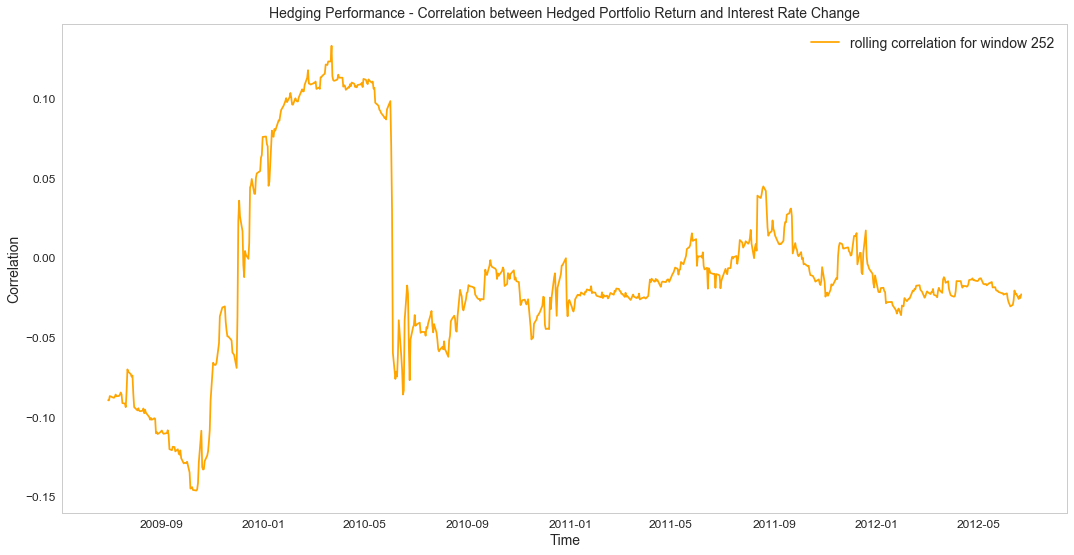

In [256]:
# data_merge_for_hedging(dur1,dur2,price1,price2,ten_yr_treasury)
hedge_info=data_merge_for_hedging(pd.DataFrame(all_rollings_bmk_test['(1, 0.5, 10, 10, 0.01)']),fut_dur,pd.DataFrame(TBAs[4.5]['price']),fut_price,rate_Base)

# hedge_perform(hedge_info,window,notional=100,startDate=np.nan)
hedge_result=hedge_perform(hedge_info,252,notional=100,startDate='2008-01-01')
hedge_result.head()

dur1     dur2     price1     price2  rate_change  hedge_ratio  \
2008-06-24  0.018228  6.22073  91.515625  112.93750     -0.00053     0.002374   
2008-06-25  0.051741  5.67760  91.579167  112.78125      0.00002     0.007400   
2008-06-26 -0.024153  6.22855  92.023177  113.65625     -0.00024    -0.003140   
2008-06-27 -0.110010  5.68709  92.446875  113.82812     -0.00120    -0.015710   
2008-06-30 -0.136756  5.68731  92.527734  113.92188      0.00027    -0.019530   

            naked_return  hedging_return  portfolio_return  portfolio_IR  \
2008-06-24           NaN             NaN               NaN           NaN   
2008-06-25      0.063542       -0.000371          0.063913           NaN   
2008-06-26      0.444010        0.006475          0.437535           NaN   
2008-06-27      0.423698       -0.000540          0.424238           NaN   
2008-06-30      0.080859       -0.001473          0.082332           NaN   

            portfolio_corr  
2008-06-24             NaN  
2008-06-25             NaN  
2008-06-26             NaN  
2008-06-27             NaN  
2008-06-30             NaN

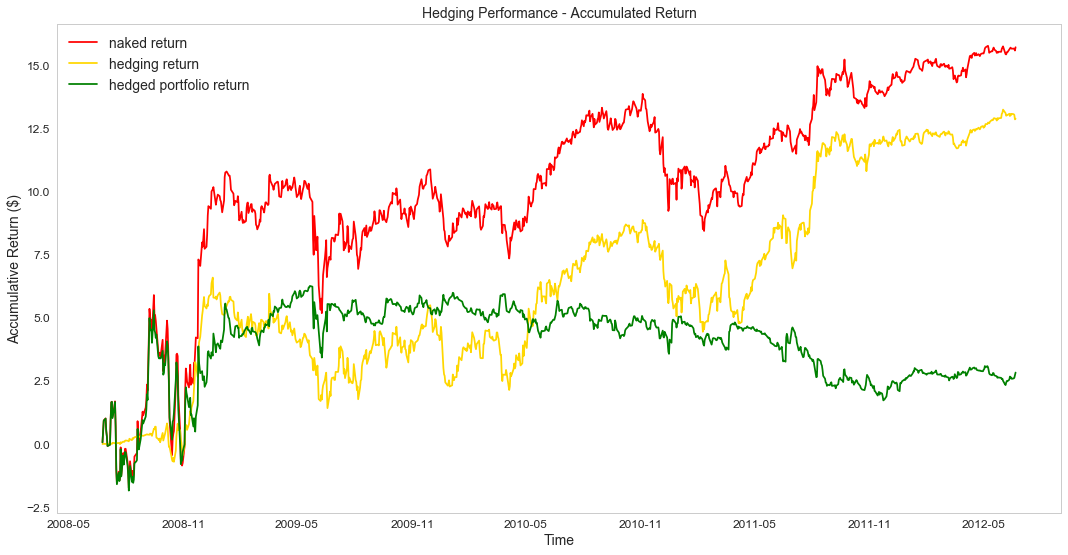

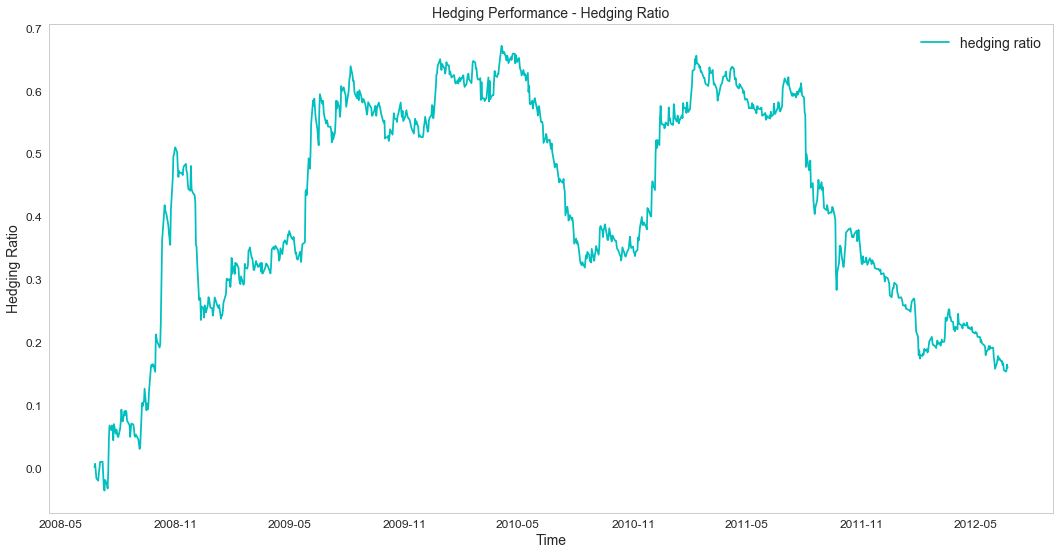

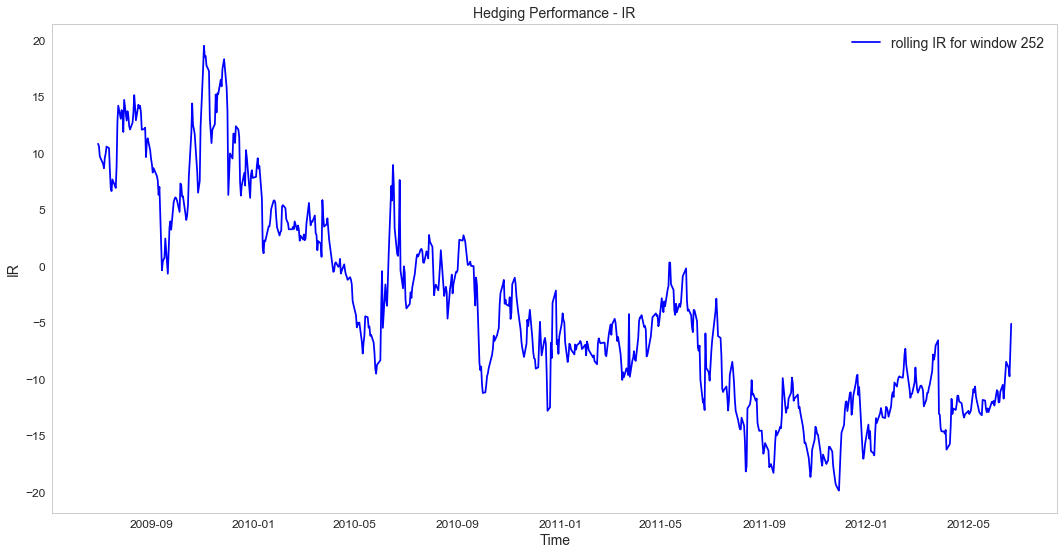

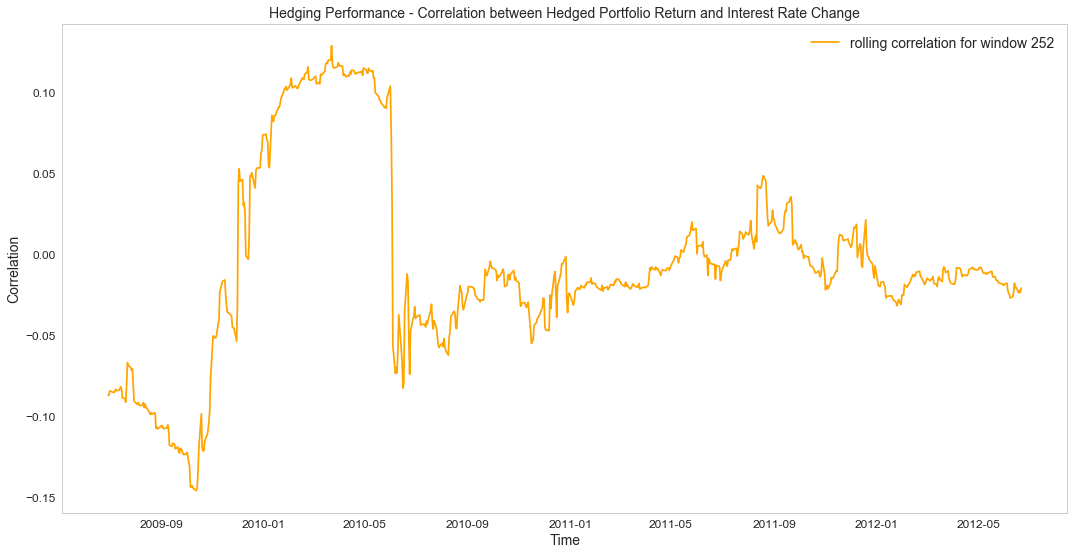

In [257]:
# data_merge_for_hedging(dur1,dur2,price1,price2,ten_yr_treasury)
hedge_info=data_merge_for_hedging(pd.DataFrame(all_rollings_bmk_test['(1, 0.5, 1, 10, 0.01)']),fut_dur,pd.DataFrame(TBAs[4.5]['price']),fut_price,rate_Base)

# hedge_perform(hedge_info,window,notional=100,startDate=np.nan)
hedge_result=hedge_perform(hedge_info,252,notional=100,startDate='2008-01-01')
hedge_result.head()

dur1     dur2     price1     price2  rate_change  hedge_ratio  \
2008-06-24  0.016798  6.22073  91.515625  112.93750     -0.00053     0.002188   
2008-06-25  0.059758  5.67760  91.579167  112.78125      0.00002     0.008547   
2008-06-26 -0.030702  6.22855  92.023177  113.65625     -0.00024    -0.003991   
2008-06-27 -0.132522  5.68709  92.446875  113.82812     -0.00120    -0.018925   
2008-06-30 -0.165408  5.68731  92.527734  113.92188      0.00027    -0.023622   

            naked_return  hedging_return  portfolio_return  portfolio_IR  \
2008-06-24           NaN             NaN               NaN           NaN   
2008-06-25      0.063542       -0.000342          0.063884           NaN   
2008-06-26      0.444010        0.007478          0.436532           NaN   
2008-06-27      0.423698       -0.000686          0.424384           NaN   
2008-06-30      0.080859       -0.001774          0.082634           NaN   

            portfolio_corr  
2008-06-24             NaN  
2008-06-25             NaN  
2008-06-26             NaN  
2008-06-27             NaN  
2008-06-30             NaN

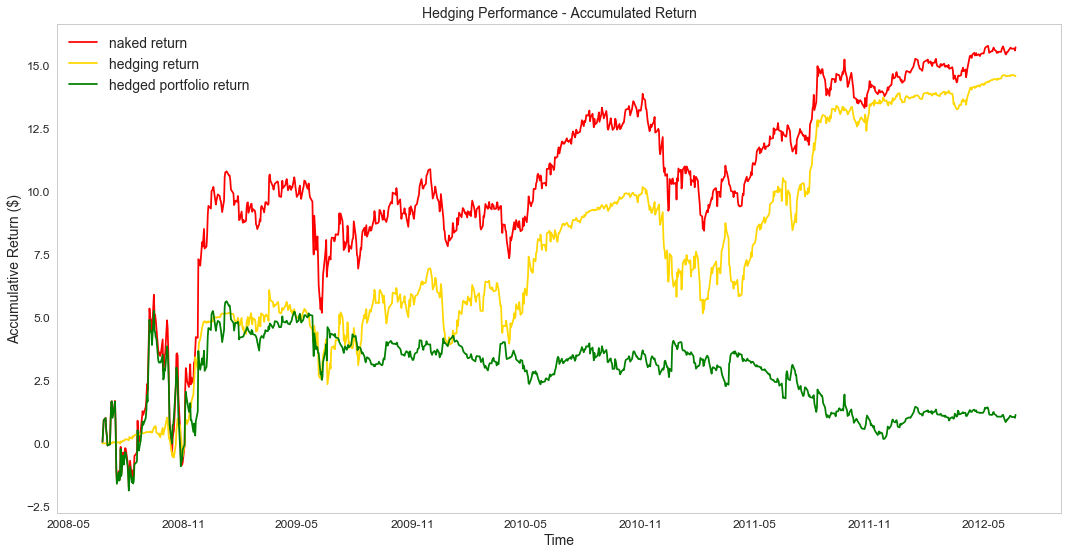

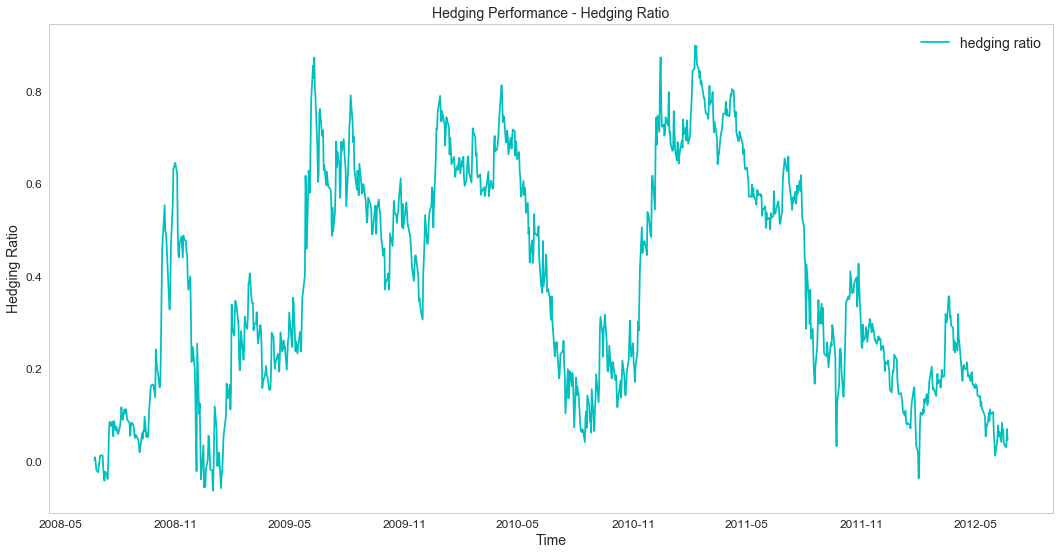

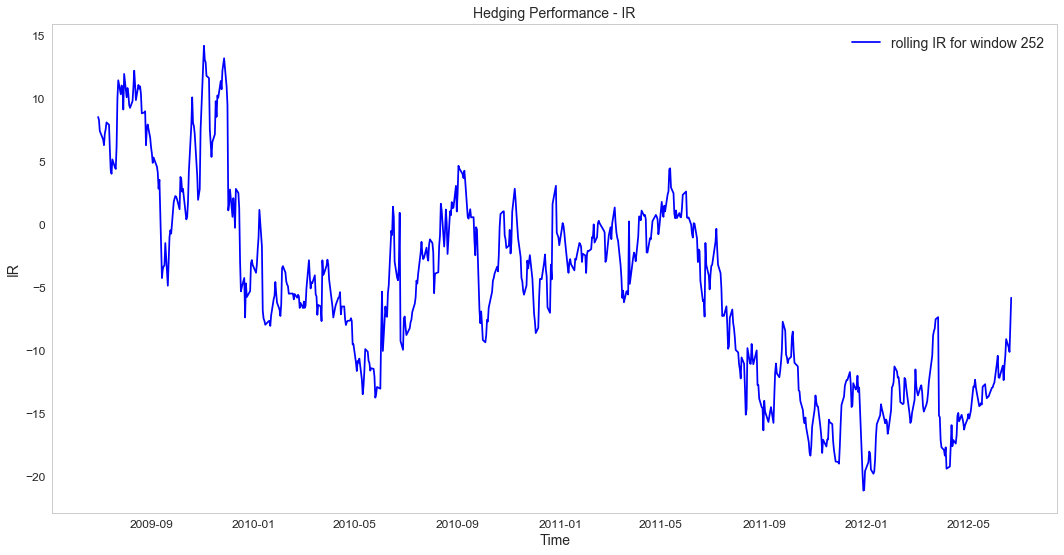

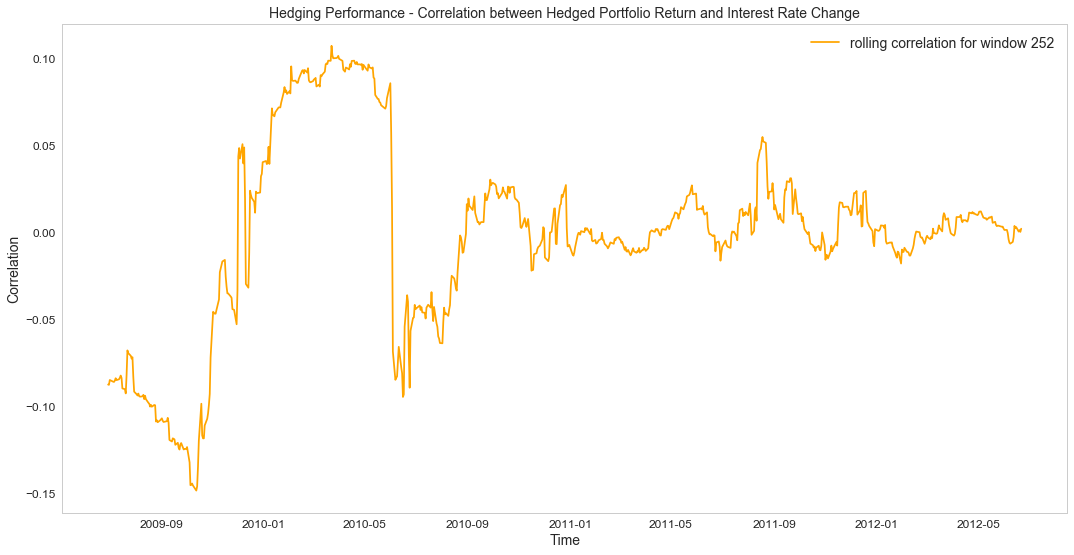

In [258]:
# data_merge_for_hedging(dur1,dur2,price1,price2,ten_yr_treasury)
hedge_info=data_merge_for_hedging(pd.DataFrame(all_rollings_bmk_test['(1, 1.0, 1, 10, 0.01)']),fut_dur,pd.DataFrame(TBAs[4.5]['price']),fut_price,rate_Base)

# hedge_perform(hedge_info,window,notional=100,startDate=np.nan)
hedge_result=hedge_perform(hedge_info,252,notional=100,startDate='2008-01-01')
hedge_result.head()

In [259]:
all_rollings_bmk_test

D3_20_wInt_imp  D3_120_wInt_imp  (1, 1.0, 10, 10, 0.01)  \
Date                                                                  
2008-06-24        7.280174         7.459835                0.015003   
2008-06-25        7.228468         7.341017               -0.022269   
2008-06-26        7.260783         7.306142                0.057511   
2008-06-27        7.306678         7.202137                0.140892   
2008-06-30        6.489705         7.047388                0.171861   
2008-07-01        6.716427         7.065475                0.109992   
2008-07-02        6.898132         7.090243                0.065106   
2008-07-03        6.819790         7.093307               -0.000499   
2008-07-07        7.796386         7.147149               -0.000166   
2008-07-08        7.482387         7.138208                0.276080   
2008-07-09        5.371257         6.974359                0.443089   
2008-07-10        6.885641         6.920908                0.443498   
2008-07-11        5.733851         6.848811                0.478351   
2008-07-14        7.070706         7.020027                0.505259   
2008-07-15        4.171154         6.790290                0.549854   
2008-07-16        4.080816         6.816276                0.639511   
2008-07-17        6.501906         7.034215                0.794979   
2008-07-18       10.967193         7.420215                0.827047   
2008-07-21       10.050603         7.740960                0.940306   
2008-07-22        9.234950         7.661693                0.901823   
2008-07-23        9.317452         7.740446                0.928171   
2008-07-24        8.948010         7.602561                1.431630   
2008-07-25        7.809930         7.362007                1.487524   
2008-07-28        8.660364         7.711388                1.727376   
2008-07-29        8.063227         7.490100                1.704556   
2008-07-30        8.103645         7.613834                1.763711   
2008-07-31        7.929172         7.575114                1.815634   
2008-08-01        7.713589         7.437321                1.826821   
2008-08-04        7.699044         7.498984                1.867166   
2008-08-05        7.556837         7.731232                1.869603   
...                    ...              ...                     ...   
2012-05-10        3.657537         1.156324                1.350723   
2012-05-11        2.379390         1.261941                1.253287   
2012-05-14        0.583707         1.081993                1.201194   
2012-05-15       -0.590897         0.988681                1.184923   
2012-05-16       -2.111813         0.980618                1.162871   
2012-05-17       -2.223969         0.892498                0.932818   
2012-05-18       -0.833262         0.519831                1.017922   
2012-05-21       -0.442947         0.749924                1.094027   
2012-05-22       -0.192635         0.938389                1.178837   
2012-05-23        0.181053         1.095484                1.081137   
2012-05-24        0.091455         0.960485                1.204379   
2012-05-25        0.223353         1.188309                1.155963   
2012-05-29        0.267649         1.098099                1.184977   
2012-05-30        0.121654         1.146334                0.947376   
2012-05-31        1.716018         0.822787                0.837234   
2012-06-01        2.839596         0.757415                0.678349   
2012-06-04        3.067411         0.700581                0.781153   
2012-06-05        1.771215         0.813640                0.851928   
2012-06-06        1.096912         0.858541                0.959864   
2012-06-07        0.533716         0.989983                0.861432   
2012-06-08        0.599427         0.845235                0.914023   
2012-06-11        0.646636         0.900642                0.855091   
2012-06-12        1.107376         0.750918                1.001325   
2012-06-13        0.326325         1

## 3.4. Kalman Filter for (d): PCA $price = \alpha_t + \beta_t * rate + \gamma_t * rate^2$

### 3.4.2. PCA Self-implementation

In [232]:
from numpy.linalg import svd, lstsq

def regPC(y, X):
    u, s, v = svd(X, full_matrices=0)
    pc =np.dot(u, np.diag(s))
    X_hat = np.hstack((pc, np.ones([len(y), 1])))
    beta_hat, _, _, _ = np.linalg.lstsq(X_hat, y)
    beta = np.dot(v.T, beta_hat[:-1])
    
    beta_raw = beta.tolist()[0]
    b1 = beta_raw[0]
    b2 = beta_raw[1]*2/beta_raw[0]
    dur = b1*(1+b2*X[-1, 0])
    
    return dur

In [238]:
D3_20_wInt_imp = []

for t in range(len(rates) - window_20):
    y = prices[t : t+window_20]
    x = rates[t : t+window_20]*100
    dur = regPC(y, np.asmatrix([x, x**2]).T)
    D3_20_wInt_imp.append(-dur)
D3_20_wInt_imp=pd.DataFrame(D3_20_wInt_imp,columns=['D3_20_wInt'],index=data.index[window_20:])

D3_120_wInt_imp = []
for t in range(len(rates) - window_120):
    y = prices[t : t+window_120]
    x = rates[t : t+window_120]*100
    dur = regPC(y, np.asmatrix([x, x**2]).T)
    D3_120_wInt_imp.append(-dur)
D3_120_wInt_imp=pd.DataFrame(D3_120_wInt_imp,columns=['D3_120_wInt'],index=data.index[window_120:])  

In [239]:
ini_mean = [0,D3_120_wInt_imp.iloc[0,0] , 100]
state_cov = np.array([1])
obs_cov = np.array([0.5, 1])
trans_cov1 = np.array([1, 10])
trans_cov2 = np.array([10])
trans_cov3 = np.array([0.01])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov1, trans_cov2, trans_cov3))
d_bf_em_3_4 = kf_duration_by_poly_fit_test(all_test_cases, ini_mean, prices, rates, Total_T, window_120, full_dates)

runing for case :  (1, 0.5, 1, 10, 0.01)
runing for case :  (1, 0.5, 10, 10, 0.01)
runing for case :  (1, 1.0, 1, 10, 0.01)
runing for case :  (1, 1.0, 10, 10, 0.01)


In [240]:
all_ols_dur=[D3_20_wInt_imp, D3_120_wInt_imp]
all_ols_key=['D3_20_wInt_imp','D3_120_wInt_imp']
all_rollings_bmk = all_ols_dur[0]
for i in np.arange(1, len(all_ols_dur)):
    all_rollings_bmk  = all_rollings_bmk.join(all_ols_dur[i], on=None, how='inner', rsuffix=all_ols_key[i][1:])

In [241]:
case_col_names = []
all_rollings_bmk_test = all_rollings_bmk.copy()
for i, m in d_bf_em_3_4.items():
    case_col_names.append(str(i))
    all_rollings_bmk_test = all_rollings_bmk_test.join(m, on=None, how='inner', rsuffix=str(i))
all_rollings_bmk_test.columns = all_ols_key + case_col_names

Index(['D3_20_wInt', 'D3_120_wInt'], dtype='object')


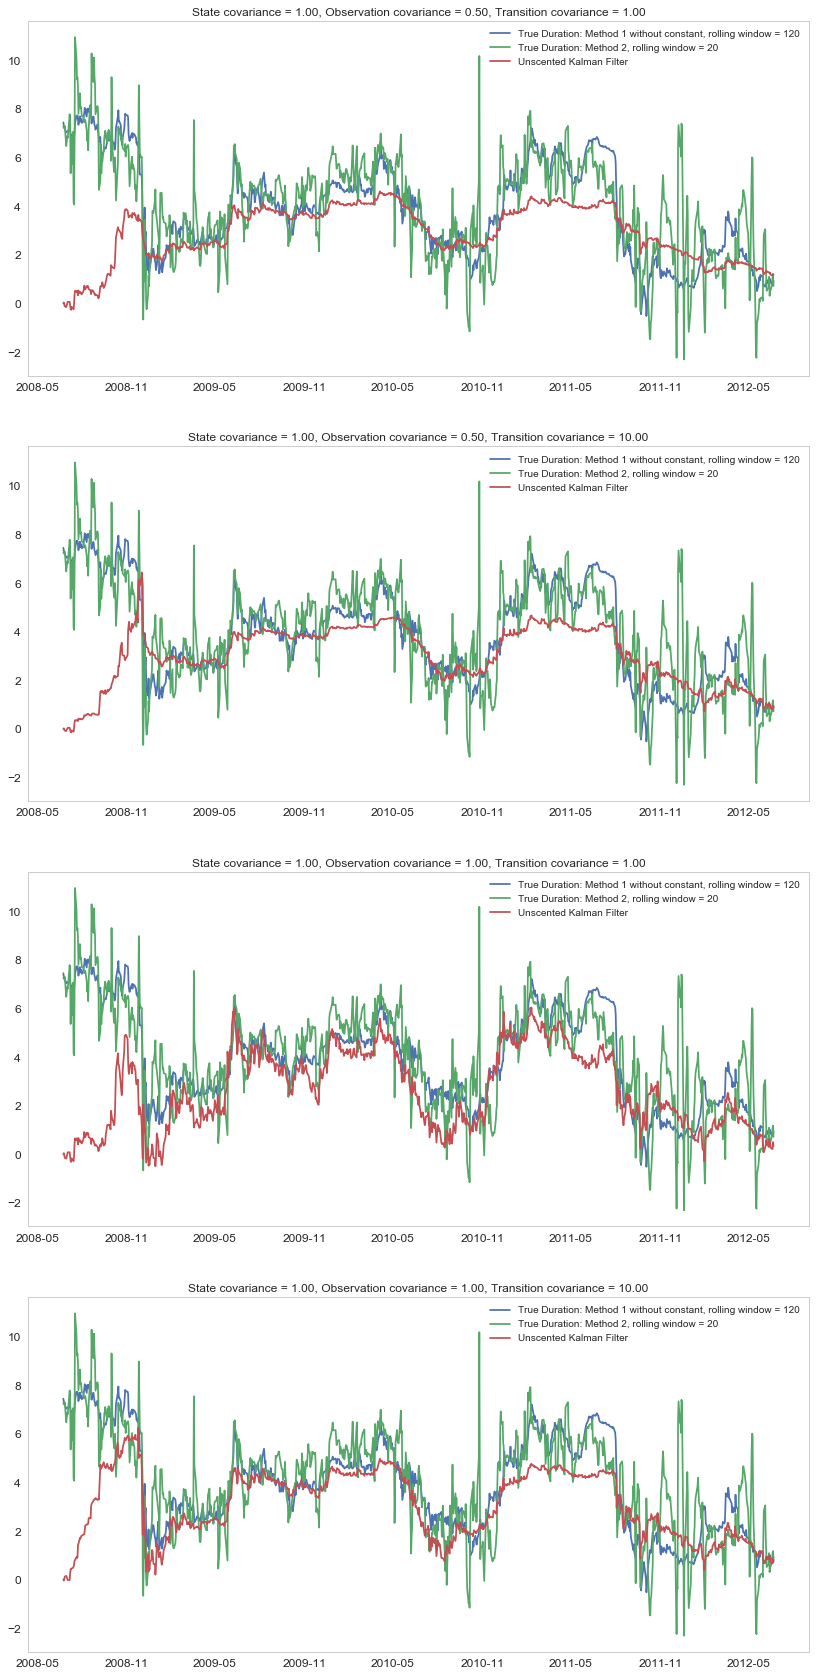

In [242]:
fig = plt.figure(figsize=(14, 30))
size = len(all_test_cases)

print(all_rollings_bmk.columns)

for i, test_case in enumerate(all_test_cases[:16], 1):
    #single_dur_m = d_af_em_3_2[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(all_rollings_bmk_test.index, all_rollings_bmk_test['D3_120_wInt_imp'], label = \
             'True Duration: Method 1 without constant, rolling window = 120')
    ax.plot(all_rollings_bmk_test.index, all_rollings_bmk_test['D3_20_wInt_imp'], \
             label = 'True Duration: Method 2, rolling window = 20')
    ax.plot(all_rollings_bmk_test.index, all_rollings_bmk_test[str(test_case)], label = 'Unscented Kalman Filter')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], \
                test_case[1], test_case[2]))

## 3.5. Kalman Filter for (e): $\frac{\Delta price}{price} = \beta_1* \Delta rate + \beta_2\beta_1 \cdot r\Delta rate$

## $Duration = -\frac{\beta_1 + \beta_3 \cdot r}{ P}$

In [21]:
def calc_duration_def(beta, ret, rates, prices, delta_r):

def calc_duration_def(beta, ret, rates, prices, delta_r):
def calc_duration_def(beta, ret, rates, prices, delta_r):def calc_duration_def(beta, ret, rates, prices, delta_r):

def calc_duration_def(beta, ret, rates, prices, delta_r):

    x = np.expand_dims(np.vstack((np.ones(len(rates)), rates)).T, axis=1).squeeze()
    d = -np.sum(x*beta,  axis = 1)
    return d

def kf_duration_by_mnyness_test(test_list, ini_mean, prices, ret, Rates, delta_r, Total_T, window, coupon):

    '''
    Run regression between price and rate, take derivative. duration = - derivative / price
    
    test_list = [(state_cov, obs_cov, trans_cov), ...]
    '''
    d_bf_em= {}
    d_af_em= {}
    dim = len(ini_mean)
    
    #Prepare Observation matrix     
    delta_r_window = delta_r[window:Total_T + window]
    rates_window = Rates[window:Total_T + window]
    
    obs_mat_r = np.expand_dims(np.vstack((delta_r_window,rates_window*delta_r_window)).T, axis=1)
    
    #Getting duration from the Kalman Filter Model
    for test_case in test_list:
        print('runing for case : ', test_case)
        state_cov, obs_cov, trans_cov = test_case
        res,res_m = beta_from_kalman_filter(np.eye(dim) * state_cov,\
                                            obs_cov,\
                                            np.eye(dim) * trans_cov,\
                                            ini_mean,\
                                            ret[window:Total_T + window], \
                                            obs_mat_r)
        
        duration_before_em = calc_duration_def(res, ret[:Total_T], rates_window,prices[:Total_T], delta_r_window)
        duration = calc_duration_def(res_m, ret[:Total_T], rates_window,prices[:Total_T], delta_r_window)
        d_bf_em[test_case] = duration_before_em
        d_af_em[test_case] = duration      
    return d_bf_em,d_af_em

In [22]:
init_a, init_b = 0, 0
ini_mean = [init_a, init_b]
state_cov = np.array([1, 0.1, 10])
obs_cov = np.array([0.5, 1, 2])
trans_cov = np.array([0.01, 0.5, 1])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))
d_bf_em_3_5,d_af_em_3_5 = kf_duration_by_mnyness_test(all_test_cases, ini_mean, prices, ret, rates, delta_r, Total_T, window_120, coupon=0.045)

runing for case :  (1.0, 0.5, 0.01)
runing for case :  (1.0, 0.5, 0.5)
runing for case :  (1.0, 0.5, 1.0)
runing for case :  (1.0, 1.0, 0.01)
runing for case :  (1.0, 1.0, 0.5)
runing for case :  (1.0, 1.0, 1.0)
runing for case :  (1.0, 2.0, 0.01)
runing for case :  (1.0, 2.0, 0.5)
runing for case :  (1.0, 2.0, 1.0)
runing for case :  (0.10000000000000001, 0.5, 0.01)
runing for case :  (0.10000000000000001, 0.5, 0.5)
runing for case :  (0.10000000000000001, 0.5, 1.0)
runing for case :  (0.10000000000000001, 1.0, 0.01)
runing for case :  (0.10000000000000001, 1.0, 0.5)
runing for case :  (0.10000000000000001, 1.0, 1.0)
runing for case :  (0.10000000000000001, 2.0, 0.01)
runing for case :  (0.10000000000000001, 2.0, 0.5)
runing for case :  (0.10000000000000001, 2.0, 1.0)
runing for case :  (10.0, 0.5, 0.01)
runing for case :  (10.0, 0.5, 0.5)
runing for case :  (10.0, 0.5, 1.0)
runing for case :  (10.0, 1.0, 0.01)
runing for case :  (10.0, 1.0, 0.5)
runing for case :  (10.0, 1.0, 1.0)
ru

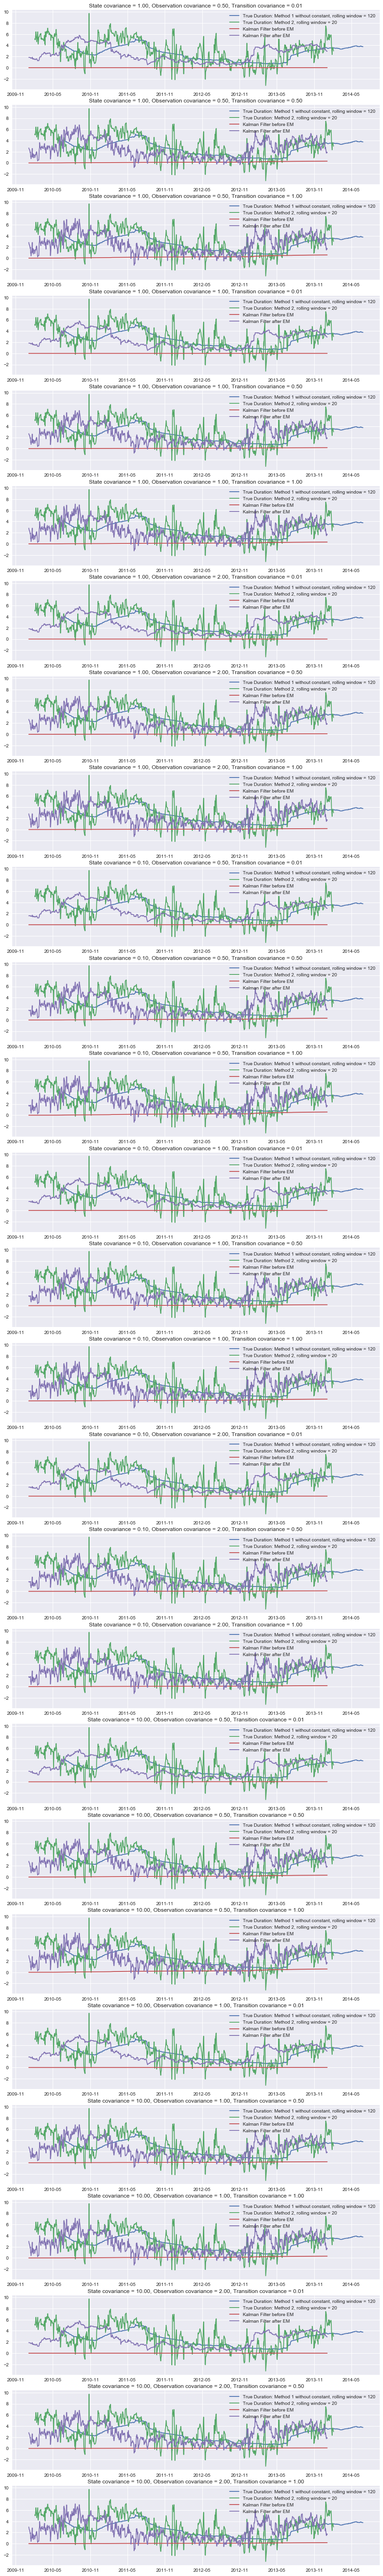

In [23]:
fig = plt.figure(figsize=(14,100))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = d_bf_em_3_5[test_case]
    single_dur_m = d_af_em_3_5[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D_120_woInt[:Total_T].index,np.array(D_120_woInt)[:Total_T], label = \
             'True Duration: Method 1 without constant, rolling window = 120')
    ax.plot(Da2_20.index[:Total_T],np.array(Da2_20)[:Total_T], \
             label = 'True Duration: Method 2, rolling window = 20')
    ax.plot(data.index[:Total_T],np.array(single_dur), label = 'Kalman Filter before EM')
    ax.plot(data.index[:Total_T],np.array(single_dur_m), label = 'Kalman Filter after EM')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], \
                test_case[1], test_case[2]))

## 3.6. MCMC

In [24]:
window = 5
D = []
for t in range(len(delta_r) - window):
    y = ret[t : t+window]
    x = delta_r[t : t+window]
    model = sm.OLS(y, x)
    result = model.fit()
    D.append(- result.params[0])

In [25]:
# MCMC
# Set up pymc3 model object with likelihood
y = ret[:Total_T]
x = delta_r[:Total_T]
model = pm.Model()
with model:
    # alpha and beta coefs
    #sigma_a = pm.HalfNormal('sigma_a',sd=.2)
    #a_t = GaussianRandomWalk('a_t', tau=sigma_a**-1, shape=T)
    sigma_b = pm.HalfNormal('sigma_b',sd=.2)
    b_t = GaussianRandomWalk('b_t', tau=sigma_b**-1, shape=Total_T)
    # Define likelihood
    sigma = pm.HalfNormal('sigma',sd=.2)
    #likelihood = pm.Normal('y', mu=a_t + b_t*x, sd=sigma, observed=y)
    likelihood = pm.Normal('y', mu=b_t*x, sd=sigma, observed=y)

# estimate
# Note: can take a while to run
with model:
    trace = pm.sample(Total_T*2, tune=Total_T)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 5,255.6: 100%|██████████| 200000/200000 [00:46<00:00, 4344.98it/s]
Finished [100%]: Average ELBO = 5,255.8
100%|██████████| 2000/2000 [02:04<00:00, 16.11it/s]


In [26]:
beta_hat = trace.get_values('b_t')
st = pd.DataFrame((pm.stats.df_summary(trace)['mean']))
st = st.ix['b_t__0':'b_t__499']

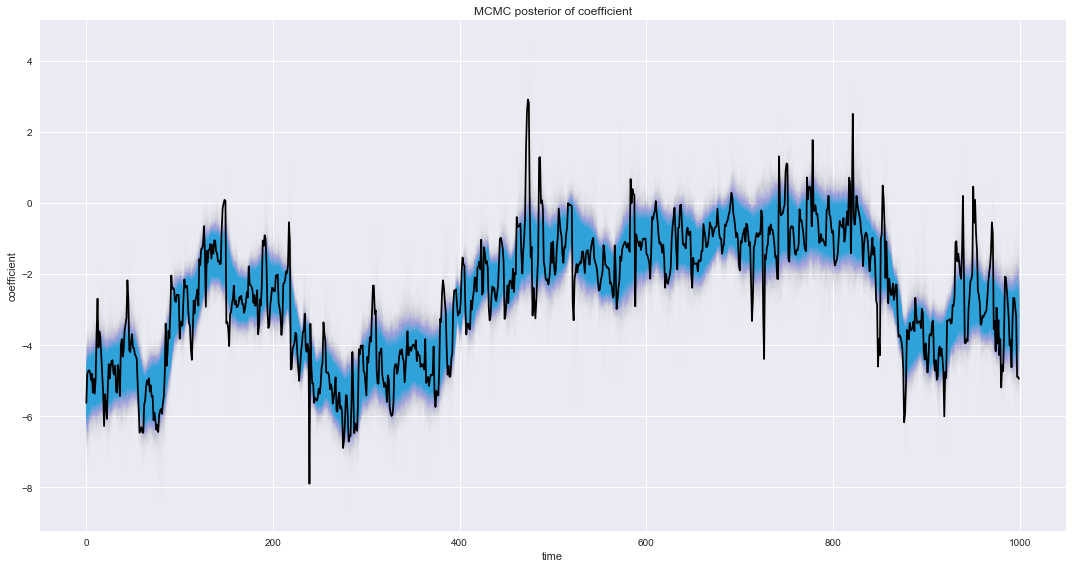

In [27]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(beta_hat.T, alpha=.0025, color='#30a2da');
ax.plot(-np.array(D[:Total_T]), color='k')
ax.set(title='MCMC posterior of coefficient', xlabel='time', ylabel='coefficient');
plt.tight_layout()

In [28]:
durations=[pd.DataFrame(D[:Total_T], columns=['Test'],index=data.index[:Total_T])]
hedge_perform(durations, '2010-01-01', swp_dur, rate_Base,notional=1,tc_ratio=0,hedge_frq=5,c=4.5)

{'Test': [-0.047349869242505664, 0.07253175506940045]}

In [ ]:
## 3.2. Kalman Filter for (b): $\frac{\Delta price}{price} = - duration_t * \Delta rate + c$

ini_mean = [np.array(-D_20_woInt)[0,0], 0]
state_cov = np.array([1, 0.1])
obs_cov = np.array([1e-5, 1])
trans_cov1 = np.array([1])
trans_cov2 = np.array([0.001])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov1, trans_cov2))
d_bf_em_3_2,d_af_em_3_2 = kf_duration_by_definition_test(all_test_cases, ini_mean, ret, delta_r, Total_T, window_120, True,data)

fig = plt.figure(figsize=(14,30))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases[:16], 1):
    single_dur = d_bf_em_3_2[test_case]
    single_dur_m = d_af_em_3_2[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D_120_woInt[:Total_T].index,np.array(D_120_woInt)[:Total_T], label = \
             'True Duration: Method 1 without constant, rolling window = 120')
    ax.plot(Da2_20.index[:Total_T],np.array(Da2_20)[:Total_T], \
             label = 'True Duration: Method 2, rolling window = 20')
    ax.plot(data.index[:Total_T],np.array(single_dur), label = 'Unscented Kalman Filter')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], \
                test_case[1], test_case[2]))

## 3.3. Kalman Filter for (c):  $price = \alpha_t + \beta_t * rate$

ini_mean = [np.array(D_20_woInt)[0,0], 0]

state_cov = np.array([1, 0.1])
obs_cov = np.array([1e-5, 1])
trans_cov1 = np.array([1, 10])
trans_cov2 = np.array([1, 100])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov1, trans_cov2))
d_bf_em_3_3,d_af_em_3_3 = kf_duration_by_poly_fit_test(all_test_cases, ini_mean, prices, rates, Total_T, window_120)

fig = plt.figure(figsize=(14,100))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = d_bf_em_3_3[test_case]
    single_dur_m = d_af_em_3_3[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D_120_woInt[:Total_T].index,np.array(D_120_woInt)[:Total_T], label = \
             'True Duration: Method 1 without constant, rolling window = 120')
    ax.plot(Da2_20.index[:Total_T],np.array(Da2_20)[:Total_T], \
             label = 'True Duration: Method 2, rolling window = 20')
    ax.plot(data.index[:Total_T],np.array(single_dur), label = 'Unscented Kalman Filter')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], \
                test_case[1], test_case[2]))

## 3.4. Kalman Filter for (d): PCA $price = \alpha_t + \beta_t * rate + \gamma_t * rate^2$

### 3.4.2. PCA Self-implementation

from numpy.linalg import svd, lstsq

def regPC(y, X):
    u, s, v = svd(X, full_matrices=0)
    pc =np.dot(u, np.diag(s))
    X_hat = np.hstack((pc, np.ones([len(y), 1])))
    beta_hat, _, _, _ = np.linalg.lstsq(X_hat, y)
    beta = np.dot(v.T, beta_hat[:-1])
    
    beta_raw = beta.tolist()[0]
    b1 = beta_raw[0]
    b2 = beta_raw[1]*2/beta_raw[0]
    dur = b1*(1+b2*X[-1, 0])
    
    return dur

D3_20_wInt_imp = []

for t in range(len(rates) - window_20):
    y = prices[t : t+window_20]
    x = rates[t : t+window_20]*100
    dur = regPC(y, np.asmatrix([x, x**2]).T)
    D3_20_wInt_imp.append(dur)
D3_20_wInt_imp=pd.DataFrame(D3_20_wInt_imp,columns=['D3_20_wInt'],index=data.index[window_20:])

D3_120_wInt_imp = []
for t in range(len(rates) - window_120):
    y = prices[t : t+window_120]
    x = rates[t : t+window_120]*100
    dur = regPC(y, np.asmatrix([x, x**2]).T)
    D3_120_wInt_imp.append(dur)
D3_120_wInt_imp=pd.DataFrame(D3_120_wInt_imp,columns=['D3_120_wInt'],index=data.index[window_120:])  

ini_mean = [init_a, init_b, 0]
state_cov = np.array([1, 0.1, 10])
obs_cov = np.array([0.5, 1, 2])
trans_cov1 = np.array([1])
trans_cov2 = np.array([0.001])
trans_cov3 = np.array([0])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov1, trans_cov2, trans_cov3))
d_bf_em_3_4,d_af_em_3_4 = kf_duration_by_poly_fit_test(all_test_cases, ini_mean, prices, rates, Total_T, window_120)

fig = plt.figure(figsize=(14,100))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = d_bf_em_3_4[test_case]
    single_dur_m = d_af_em_3_4[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D_120_woInt[:Total_T].index,np.array(D3_120_wInt_imp)[:Total_T], label = \
             'True Duration: Method PCA, rolling window = 120')
    ax.plot(Da2_20.index[:Total_T],np.array(D3_20_wInt_imp)[:Total_T], \
             label = 'True Duration: Method PCA, rolling window = 20')
    ax.plot(data.index[:Total_T],np.array(single_dur), label = 'Kalman Filter before EM')
    ax.plot(data.index[:Total_T],np.array(single_dur_m), label = 'Kalman Filter after EM')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], \
                test_case[1], test_case[2]))

## 3.5. Kalman Filter for (e): $\frac{\Delta price}{price} = \beta_1* \Delta rate + \beta_2\beta_1 \cdot r\Delta rate$

## $Duration = -\frac{\beta_1 + \beta_3 \cdot r}{ P}$

def calc_duration_def(beta, ret, rates, prices, delta_r):
    x = np.expand_dims(np.vstack((np.ones(len(rates)), rates)).T, axis=1).squeeze()
    d = -np.sum(x*beta,  axis = 1)
    return d

def kf_duration_by_mnyness_test(test_list, ini_mean, prices, ret, Rates, delta_r, Total_T, window, coupon):

    '''
    Run regression between price and rate, take derivative. duration = - derivative / price
    
    test_list = [(state_cov, obs_cov, trans_cov), ...]
    '''
    d_bf_em= {}
    d_af_em= {}
    dim = len(ini_mean)
    
    #Prepare Observation matrix     
    delta_r_window = delta_r[window:Total_T + window]
    rates_window = Rates[window:Total_T + window]
    
    obs_mat_r = np.expand_dims(np.vstack((delta_r_window,rates_window*delta_r_window)).T, axis=1)
    
    #Getting duration from the Kalman Filter Model
    for test_case in test_list:
        print('runing for case : ', test_case)
        state_cov, obs_cov, trans_cov = test_case
        res,res_m = beta_from_kalman_filter(np.eye(dim) * state_cov,\
                                            obs_cov,\
                                            np.eye(dim) * trans_cov,\
                                            ini_mean,\
                                            ret[window:Total_T + window], \
                                            obs_mat_r)
        
        duration_before_em = calc_duration_def(res, ret[:Total_T], rates_window,prices[:Total_T], delta_r_window)
        duration = calc_duration_def(res_m, ret[:Total_T], rates_window,prices[:Total_T], delta_r_window)
        d_bf_em[test_case] = duration_before_em
        d_af_em[test_case] = duration      
    return d_bf_em,d_af_em

init_a, init_b = 0, 0
ini_mean = [init_a, init_b]
state_cov = np.array([1, 0.1, 10])
obs_cov = np.array([0.5, 1, 2])
trans_cov = np.array([0.01, 0.5, 1])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))
d_bf_em_3_5,d_af_em_3_5 = kf_duration_by_mnyness_test(all_test_cases, ini_mean, prices, ret, rates, delta_r, Total_T, window_120, coupon=0.045)

fig = plt.figure(figsize=(14,100))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = d_bf_em_3_5[test_case]
    single_dur_m = d_af_em_3_5[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D_120_woInt[:Total_T].index,np.array(D_120_woInt)[:Total_T], label = \
             'True Duration: Method 1 without constant, rolling window = 120')
    ax.plot(Da2_20.index[:Total_T],np.array(Da2_20)[:Total_T], \
             label = 'True Duration: Method 2, rolling window = 20')
    ax.plot(data.index[:Total_T],np.array(single_dur), label = 'Kalman Filter before EM')
    ax.plot(data.index[:Total_T],np.array(single_dur_m), label = 'Kalman Filter after EM')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], \
                test_case[1], test_case[2]))

## 3.6. MCMC

window = 5
D = []
for t in range(len(delta_r) - window):
    y = ret[t : t+window]
    x = delta_r[t : t+window]
    model = sm.OLS(y, x)
    result = model.fit()
    D.append(- result.params[0])

# MCMC
# Set up pymc3 model object with likelihood
y = ret[:Total_T]
x = delta_r[:Total_T]
model = pm.Model()
with model:
    # alpha and beta coefs
    #sigma_a = pm.HalfNormal('sigma_a',sd=.2)
    #a_t = GaussianRandomWalk('a_t', tau=sigma_a**-1, shape=T)
    sigma_b = pm.HalfNormal('sigma_b',sd=.2)
    b_t = GaussianRandomWalk('b_t', tau=sigma_b**-1, shape=Total_T)
    # Define likelihood
    sigma = pm.HalfNormal('sigma',sd=.2)
    #likelihood = pm.Normal('y', mu=a_t + b_t*x, sd=sigma, observed=y)
    likelihood = pm.Normal('y', mu=b_t*x, sd=sigma, observed=y)

# estimate
# Note: can take a while to run
with model:
    trace = pm.sample(Total_T*2, tune=Total_T)

beta_hat = trace.get_values('b_t')
st = pd.DataFrame((pm.stats.df_summary(trace)['mean']))
st = st.ix['b_t__0':'b_t__499']

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(beta_hat.T, alpha=.0025, color='#30a2da');
ax.plot(-np.array(D[:Total_T]), color='k')
ax.set(title='MCMC posterior of coefficient', xlabel='time', ylabel='coefficient');
plt.tight_layout()

durations=[pd.DataFrame(D[:Total_T], columns=['Test'],index=data.index[:Total_T])]
hedge_perform(durations, '2010-01-01', swp_dur, rate_Base,notional=1,tc_ratio=0,hedge_frq=5,c=4.5)